In [1]:
import os
import warnings

import matplotlib.patheffects as path_effects
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from math import sqrt
from patsy import dmatrices
from scipy.stats import probplot, shapiro, ttest_ind
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (accuracy_score, adjusted_rand_score, auc, average_precision_score,
                             classification_report, confusion_matrix, f1_score,
                             make_scorer, mean_absolute_error, mean_squared_error,
                             precision_score, recall_score, r2_score, roc_auc_score, roc_curve,
                             silhouette_score)
from sklearn.model_selection import (KFold, StratifiedKFold, cross_val_score, learning_curve,
                                     train_test_split)
from sklearn.preprocessing import StandardScaler
from statsmodels.api import OLS
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import OLSInfluence, variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
from tabulate import tabulate

from functions import *

# Configuration
os.environ["OMP_NUM_THREADS"] = '1'
warnings.filterwarnings('ignore')

# Détection de faux billets

Dans ce projet, nous travaillons avec un ensemble de données de 1500 billets, contenant des informations géométriques ainsi que leur nature (vrai ou faux). Notre objectif est de construire un modèle capable de prédire si un billet est vrai ou faux, en se basant sur ces informations.

Commençons par importer les données et explorer leur structure.


# 1. Importation et Familiarisation avec les Données

In [2]:
# Importation des fichiers.
billets = pd.read_csv("billets.csv", sep=";")

# Création d'une copie dans un dataframe.
df_billets = billets.copy()

# Exploration des données

Maintenant que nous avons chargé nos données, explorons-les un peu plus. Nous allons :

1. Afficher 10 lignes aléatoires pour observer nos données ;
2. Afficher des statistiques descriptives pour avoir une vue d'ensemble de nos variables ;
3. Vérifier les types de données pour s'assurer qu'ils sont corrects ;
4. Vérifier la présence de valeurs NaN ;
5. Rechercher des lignes entièrement dupliquées ;


In [3]:
# Affichage de 10 lignes et observation de la forme du dataframe.
print(df_billets.shape)
df_billets.sample(10)

(1500, 7)


is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
883         True    171.73       104.38        103.26        4.00       3.04   
1204       False    171.96       104.01        104.54        5.21       3.31   
467         True    171.80       104.06        103.57        4.06       3.14   
1171       False    171.86       103.94        103.81        5.12       3.23   
268         True    171.47       104.30        104.01        4.32       2.68   
468         True    171.83       103.97        104.00        3.72       3.13   
829         True    172.26       104.14        103.73        4.41       2.96   
598         True    171.67       103.88        103.94        4.20       2.93   
901         True    171.83       104.08        103.70        3.28       2.88   
129         True    172.00       104.05        103.67        4.02       3.18   

      length  
883   112.72  
1204  111.35  
467   112.98  
1171  111.55  
268   113.07  
468   113.83  
829   112.91  
598   112.84  
901   113.56  
129   113.40

In [4]:
# Affichage de statistiques descriptives sur le dataframe.
df_billets.describe(include="all")

is_genuine     diagonal  height_left  height_right   margin_low  \
count        1500  1500.000000  1500.000000   1500.000000  1463.000000   
unique          2          NaN          NaN           NaN          NaN   
top          True          NaN          NaN           NaN          NaN   
freq         1000          NaN          NaN           NaN          NaN   
mean          NaN   171.958440   104.029533    103.920307     4.485967   
std           NaN     0.305195     0.299462      0.325627     0.663813   
min           NaN   171.040000   103.140000    102.820000     2.980000   
25%           NaN   171.750000   103.820000    103.710000     4.015000   
50%           NaN   171.960000   104.040000    103.920000     4.310000   
75%           NaN   172.170000   104.230000    104.150000     4.870000   
max           NaN   173.010000   104.880000    104.950000     6.900000   

          margin_up      length  
count   1500.000000  1500.00000  
unique          NaN         NaN  
top             NaN         NaN  
freq            NaN         NaN  
mean       3.151473   112.67850  
std        0.231813     0.87273  
min        2.270000   109.49000  
25%        2.990000   112.03000  
50%        3.140000   112.96000  
75%        3.310000   113.34000  
max        3.910000   114.44000

In [5]:
# Vérification des types de données et de la présence de valeurs NaN.
df_billets.info()
df_billets.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

In [6]:
# Recherche de lignes entièrement dupliquées. 
df_billets.duplicated().sum()

0

 * Nous disposons des six caractéristiques géométriques suivantes pour chaque billet :

    1. `length` : la longueur du billet (en mm) ;
    2. `height_left` : la hauteur du billet (mesurée sur le côté gauche, en mm) ;
    3. `height_right` : la hauteur du billet (mesurée sur le côté droit, en mm) ;
    4. `margin_up` : la marge entre le bord supérieur du billet et l'image de celui-ci (en mm) ;
    5. `margin_low` : la marge entre le bord inférieur du billet et l'image de celui-ci (en mm) ;
    6. `diagonal` : la diagonale du billet (en mm) ;

 
* 1500 billets au total.
  
- 37 NaN dans la colonne `margin_low`.

***

# 2. Prétraitement et Analyse Exploratoire des Données


Nous allons suivre les étapes suivantes :

1. Encodage des variables catégorielles : Nous avons une variable booléenne ``is_genuine`` que nous allons encoder en 0 et 1.
   
2. Identification et traitement des valeurs nulles : Nous allons utiliser une régression linéaire pour imputer les 37 valeurs manquantes de '``margin_low``'.
   
3. Analyse exploratoire des données : Nous allons effectuer une analyse univariée et bivariée pour comprendre la distribution des variables, leurs statistiques descriptives et les relations entre elles.


## 2.1 Encodage des Variables Catégorielles

In [7]:
#Encodage de la variable booléenne.
df_billets["is_genuine"] = df_billets["is_genuine"].map({True : 1, False : 0})

## 2.2 Imputation des valeurs manquantes

* Les 37 valeurs manquantes de 'margin_low' seront imputées par une régression linéaire.
* Nous rechercherons les corrélations linéaires entre les variables numériques pour trouver celle la plus corrélée à "margin_low".


Commençons par analyser les relations entre **"margin_low"** et les autres variables

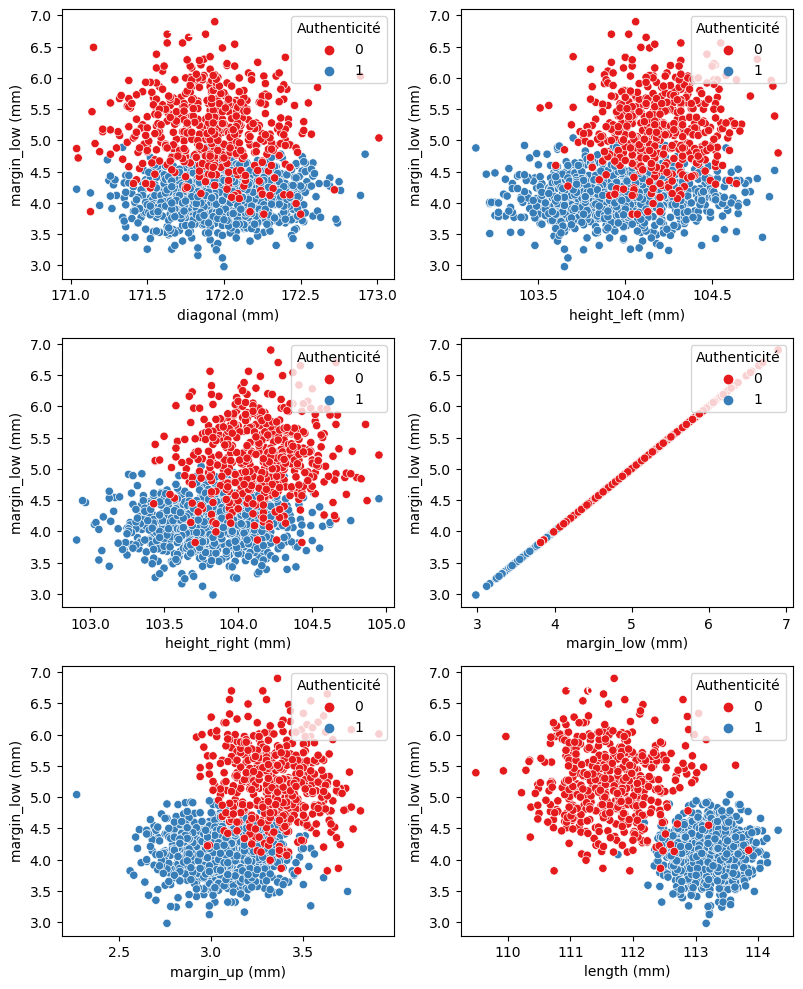

In [8]:
# Création d'une figure et de sous-graphiques avec 3 lignes et 2 colonnes
fig, axes = plt.subplots(3, 2, figsize=(8, 10))

# Liste des variables à analyser
variables = df_billets.columns[1:]

# Calcul des corrélations de chaque variable avec "margin_low"
correlations = df_billets[variables].corr()["margin_low"]

# Pour chaque variable
for i, col in enumerate(variables):
    # Sélection du sous-graphique correspondant
    ax = axes[i // 2, i % 2]
    
    # Création d'un diagramme de dispersion pour la variable et "margin_low"
    sns.scatterplot(data=df_billets, x=col, y="margin_low", hue="is_genuine", ax=ax, palette="Set1")
    
    # Définition des étiquettes des axes
    ax.set_xlabel(f"{col} (mm)")
    ax.set_ylabel("margin_low (mm)")
    
    # Ajout d'une légende
    ax.legend(title="Authenticité", loc="upper right")
    
    # Affichage de la corrélation sur le graphique
    text = ax.text(0.05, 0.9, f"Corrélation : {correlations[col]:.2f}", transform=ax.transAxes,\
                   color='white', fontsize=10)

# Ajustement de la disposition pour une meilleure lisibilité
plt.tight_layout()

# Affichage de la figure
plt.show()


## 2.2.2 Régression Linéaire Simple

### Sélection des Features

Nous allons créer deux ensembles de données :
- `df_train` contient les lignes où ``margin_low`` n'est pas nul. Cet ensemble sera utilisé pour entraîner le modèle de régression linéaire.
- `df_impute` contient les lignes où `margin_low` est nul. Cet ensemble sera utilisé pour prédire les valeurs manquantes de `margin_low`.


In [9]:
# Création d'un DataFrame contenant seulement les lignes où 'margin_low' n'est pas nul
df_train = df_billets[df_billets['margin_low'].notnull()]

# Création d'un DataFrame contenant seulement les lignes où 'margin_low' est nul
df_impute = df_billets[df_billets['margin_low'].isnull()]

In [10]:
# Sélection des variables indépendantes pour la régression linéaire
features = ["length"]

# Définition de la variable cible
cible = "margin_low"

# Sélection des variables indépendantes dans l'ensemble d'entraînement
X = df_train[features]

# Sélection de la variable dépendante dans l'ensemble d'entraînement
y = df_train[cible]

# Cross Validation et Modélisation

Nous allons initialiser un modèle de régression linéaire et créer un objet KFold pour la validation croisée.

Nous spécifions 10 plis (n_splits=10), les données seront mélangées avant la division (shuffle=True), et nous fixons un état aléatoire pour la reproductibilité (random_state=17).

Après avoir entraîné le modèle, nous afficherons l'intercept et les coefficients pour chaque feature.


In [11]:
# Initialisation du modèle de régression linéaire

model_simple = LinearRegression()
kf = KFold(n_splits=10, shuffle=True, random_state=17)

# Fit du modèle sur les données d'entraînement
model_simple.fit(X, y)

print("Intercept:", model_simple.intercept_)
print("Coefficients:")
for feature, coef in zip(features, model_simple.coef_):
    print(f"{feature}: {coef}")


Intercept: 61.5960086247053
Coefficients:
length: -0.5068574610518826


In [12]:
# Prédiction sur l'ensemble de données d'entraînement
y_pred = model_simple.predict(X)

# Calcul des résidus
residus = y - y_pred

#### Hypothèses de la Régression Linéaire

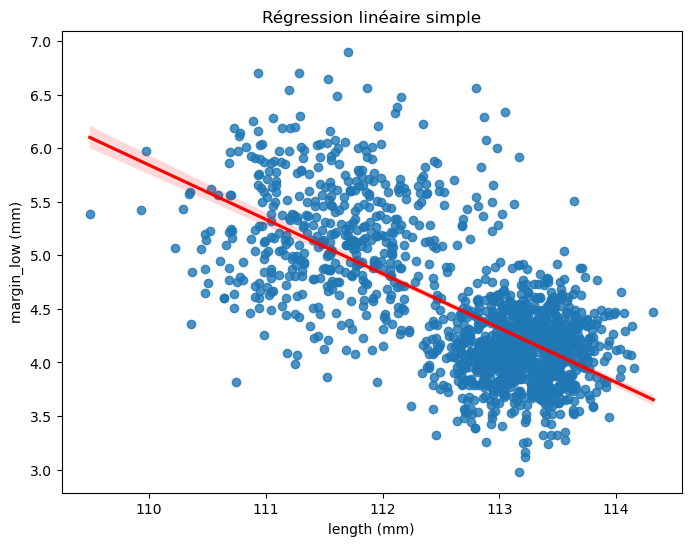

In [13]:
# Affichage des valeurs et de la droite de régression
plt.figure(figsize=(8, 6))
sns.regplot(data=df_train, x="length", y="margin_low", line_kws={"color": "red"})
plt.xlabel("length (mm)")
plt.ylabel("margin_low (mm)")
plt.title("Régression linéaire simple")
plt.show()

#### Normalité des résidus

In [14]:
# Test de Shapiro-Wilk
sw_test = shapiro(residus)

print('p-value:', sw_test[1])

p-value: 2.3925759377180222e-12


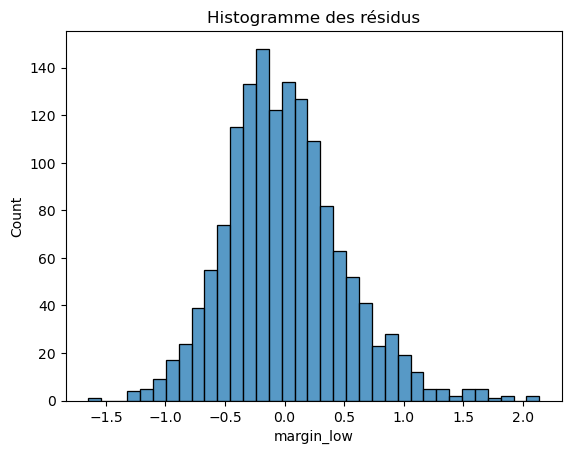

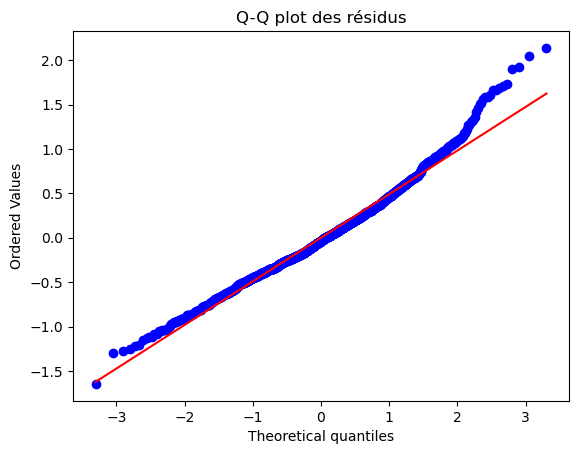

In [15]:
# Histogramme des résidus
sns.histplot(residus)
plt.title('Histogramme des résidus')
plt.show()

# Q-Q plot des résidus
probplot(residus, plot=plt)
plt.title('Q-Q plot des résidus')
plt.show()

#### Homoscédasticité

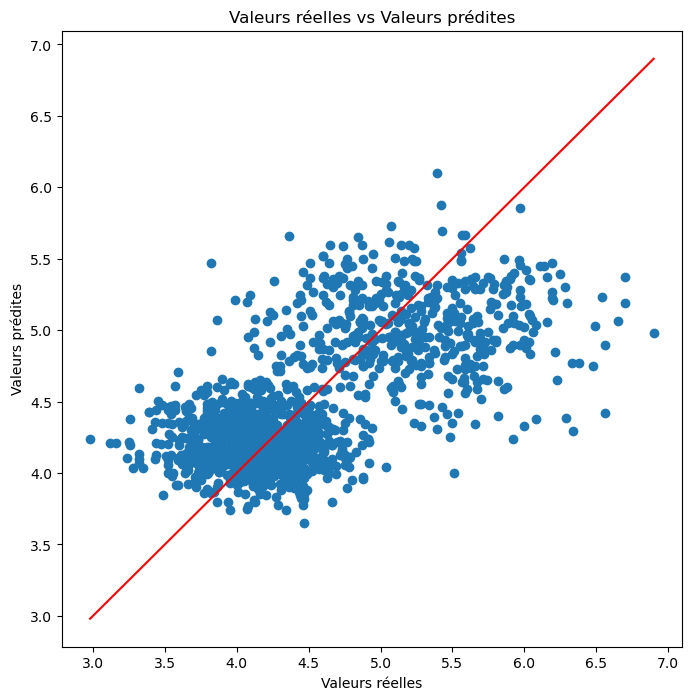

In [16]:
fig = plt.figure(figsize = (8,8))

X_plot = [billets['margin_low'].min(), billets['margin_low'].max()]

# Créer un scatterplot
plt.scatter(y, y_pred)
plt.xlabel('Valeurs réelles')
plt.ylabel('Valeurs prédites')
plt.title('Valeurs réelles vs Valeurs prédites')
plt.plot(X_plot, X_plot, color = 'red')

plt.show()

In [17]:
# Ajout d'une constante à X
X_const = sm.add_constant(X)

# Test de Breusch-Pagan
bp_test = het_breuschpagan(residus, X_const)

print('p-value:', bp_test[1])

p-value: 5.99654057106415e-15


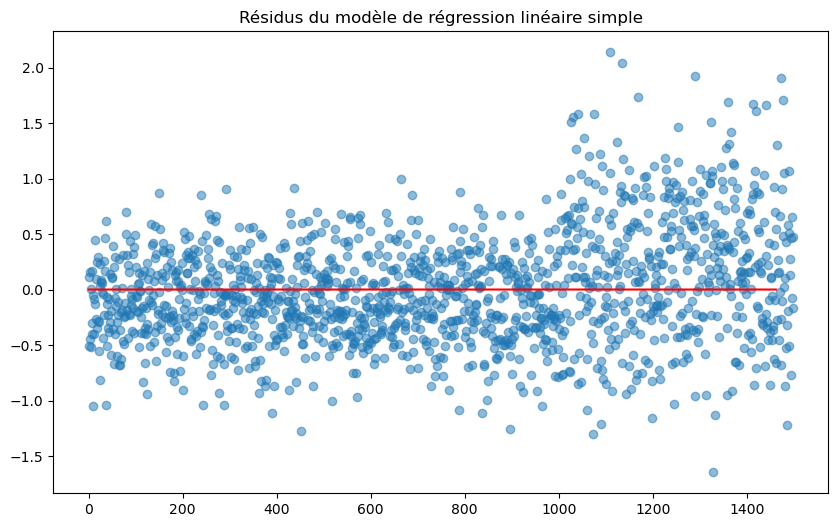

In [18]:
# Visualisation des résidus
plt.subplots(figsize=(10, 6))
plt.scatter(x=X.index, y=residus, alpha=0.5)
plt.plot(np.repeat(0, len(X.index)), color='red')
plt.title('Résidus du modèle de régression linéaire simple')
plt.show() 

# Évaluation du modèle

Nous allons calculer et afficher des indicateurs de performance, comme RMSE, MAE et MAPE, à l'aide de la fonction `evaluation_model()`.


In [19]:
evaluation_model(model_simple, kf, X, y)

indicateurs d'entraînement
Score R^2 moyen : 0.4444947116880022 
MAE moyen : 0.38322708488675705 
MSE moyen : 0.244586432439939 
MAPE moyen : 8.497751613220151

indicateurs de validation
Score R^2 moyen : 0.4396044666270179 
MAE moyen : 0.38324400842493755 
MSE moyen : 0.24461242582552006 
MAPE moyen : 8.497895157506447


***

## 2.2.3 Régression Linéaire Multiple

# Sélection des Features


In [20]:
# Sélection des variables indépendantes pour la régression linéaire
features_mul = ["is_genuine", "diagonal", "height_left", "height_right", "margin_up", "length"]

# Définition de la variable cible
cible_mul = "margin_low"

# Sélection des variables indépendantes dans l'ensemble d'entraînement
X_mul = df_train[features_mul]

# Sélection de la variable dépendante dans l'ensemble d'entraînement
y_mul = df_train[cible_mul]

# Cross Validation et Modélisation


In [21]:
# Initialisation du modèle de régression linéaire

model_multiple = LinearRegression()
kfold = KFold(n_splits=5, shuffle=True, random_state=17)

# Fit du modèle sur les données d'entraînement
model_multiple.fit(X_mul, y_mul)

print("Intercept:", model_multiple.intercept_)

print("Coefficients:")
for feature, coef in zip(features_mul, model_multiple.coef_):
    print(f"{feature}: {coef}")

Intercept: 2.8668228920543646
Coefficients:
is_genuine: -1.1405967576441582
diagonal: -0.013015902276001672
height_left: 0.02829068686804804
height_right: 0.02674981937444579
margin_up: -0.21284431603465723
length: -0.003882990840287542


In [22]:
# Prédiction sur l'ensemble de données d'entraînement
y_pred_mul = model_multiple.predict(X_mul)

# Calcul des résidus
residus_mul = y_mul - y_pred_mul

## Hypothèses de la régression

#### Normalité des résidus

In [23]:
# Test de Shapiro-Wilk
sw_mul = shapiro(residus_mul)

print('p-value:', sw_mul[1])

p-value: 7.050080967019312e-06


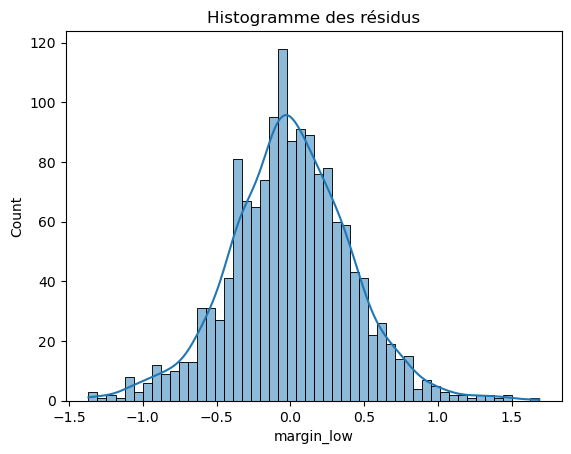

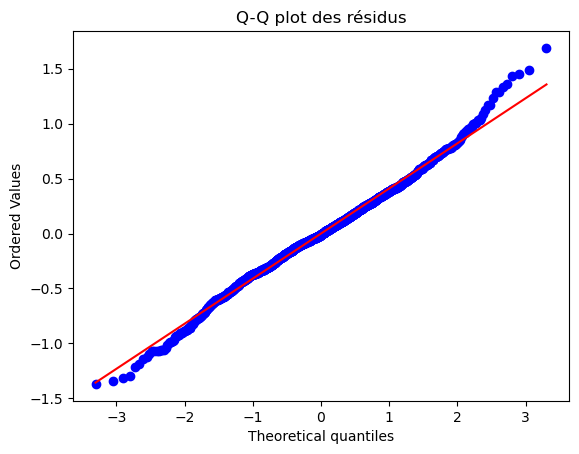

In [24]:
# Histogramme des résidus
sns.histplot(residus_mul, kde=True, bins=50)
plt.title('Histogramme des résidus')
plt.show()

# Q-Q plot des résidus
probplot(residus_mul, plot=plt)
plt.title('Q-Q plot des résidus')
plt.show()

#### Colinéarité des variables

In [25]:
# Création la matrice de conception
_, X_vif = dmatrices('margin_low~diagonal+height_left+height_right+margin_up+length+is_genuine', data=df_billets, return_type='dataframe')

# Calcul du VIF pour chaque variable explicative
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
vif['variable'] = X_vif.columns
vif[1:]

VIF      variable
1  1.028199      diagonal
2  1.173711   height_left
3  1.320836  height_right
4  1.596090     margin_up
5  3.613255        length
6  4.725732    is_genuine

Tous les coefficients sont inférieurs à 10, il n'y a donc pas de colinéarité.

In [26]:
print("Test de Durbin-Watson : ", durbin_watson(residus_mul).round(2))

Test de Durbin-Watson :  2.04


#### Homoscédasticité

In [27]:
# Ajoute une constante à X pour représenter la constante
X_const_mul = sm.add_constant(X_mul)

# Test de Breusch-Pagan
bp_test = het_breuschpagan(residus_mul, X_const_mul)

print('p-value:', bp_test[1])

p-value: 3.463957971601608e-33


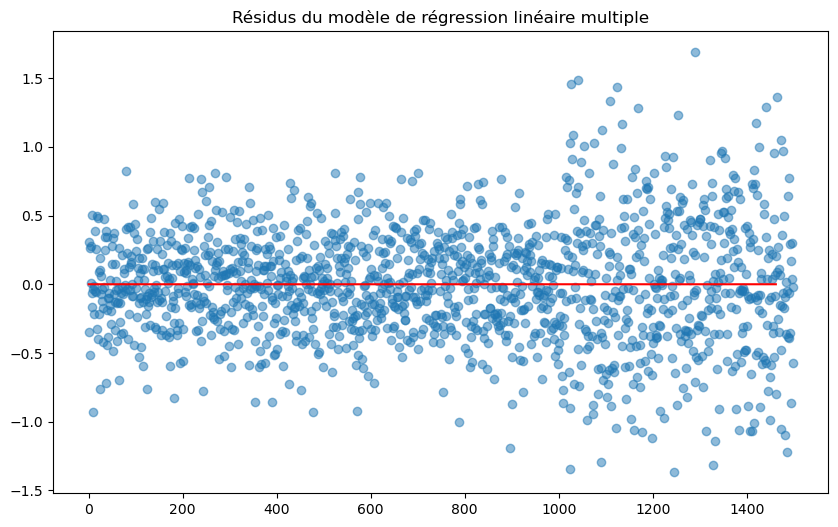

In [28]:
# Visualisation des résidus
plt.subplots(figsize=(10, 6))
plt.scatter(x=X_mul.index, y=residus_mul, alpha=0.5)
plt.plot(np.repeat(0, len(X_mul.index)), color='red')
plt.title('Résidus du modèle de régression linéaire multiple')
plt.show() 

# Évaluation du modèle


In [29]:
evaluation_model(model_multiple,kfold, X_mul,y_mul)

indicateurs d'entraînement
Score R^2 moyen : 0.6167233490341549 
MAE moyen : 0.315812516130319 
MSE moyen : 0.16870701013010952 
MAPE moyen : 7.02605752872295

indicateurs de validation
Score R^2 moyen : 0.6144975151890503 
MAE moyen : 0.3158102533479135 
MSE moyen : 0.16870581346799257 
MAPE moyen : 7.025846173560245


## Imputation 

Nous utilisons notre modèle  de regression linéaire multiple formé pour imputer les valeurs manquantes de ``margin_low``.

In [30]:
# Sélection des variables indépendantes (toutes les colonnes sauf 'margin_low') pour les valeurs manquantes
X_impute = df_impute.drop('margin_low', axis=1)

# Prédiction des valeurs manquantes en utilisant le modèle entraîné
imputed_values = model_multiple.predict(X_impute)

# Création d'une copie du DataFrame df_impute
df_impute_copy = df_impute.copy()

# Remplacement des valeurs manquantes de 'margin_low' par les valeurs prédites
df_impute_copy['margin_low'] = imputed_values[:]


Combinaison des données : Nous combinons nos données imputées avec les données d'entraînement d'origine pour obtenir un jeu de données complet.

In [31]:
# Concaténation des DataFrames df_mul_train et df_mul_impute pour former un DataFrame complet
df_billets_full = pd.concat([df_train, df_impute_copy])

In [32]:
# Calcul des statistiques pour df_billets
df_billets_stats = df_billets.describe()

# Calcul des statistiques pour df_billets_full
df_billets_full_stats = df_billets_full.describe()

# Comparaison des statistiques et mise en évidence des différences en utilisant un formatage conditionnel
comparaison = df_billets_stats.compare(df_billets_full_stats, align_axis=0).fillna(0)

# Définition d'une fonction pour colorer en noir les cellules contenant 0
def couleur_nul(val):
    if val == 0:
        return 'background-color: black'
    return ''

# Application du formatage conditionnel avec la couleur noire pour les cellules contenant 0
df_comparaison = comparaison.style \
    .background_gradient(cmap='Dark2') \
    .set_caption('Comparaison Avant/Après Imputation') \
    .applymap(couleur_nul)

# Affichage de la comparaison
df_comparaison


***

# 3. Analyse Exploratoire des Données 

In [33]:
df_billets_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1500 entries, 0 to 1438
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   int64  
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1500 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 93.8 KB


In [34]:
# Transtypage de la variable 'is_genuine' en booléen
df_billets_full['is_genuine'] = df_billets_full['is_genuine'].astype('bool')

## 3.1 Analyse univariée

╒════╤══════════╤═════════════╕
│    │   Valeur │   Effectifs │
╞════╪══════════╪═════════════╡
│  0 │        1 │        1000 │
├────┼──────────┼─────────────┤
│  1 │        0 │         500 │
╘════╧══════════╧═════════════╛


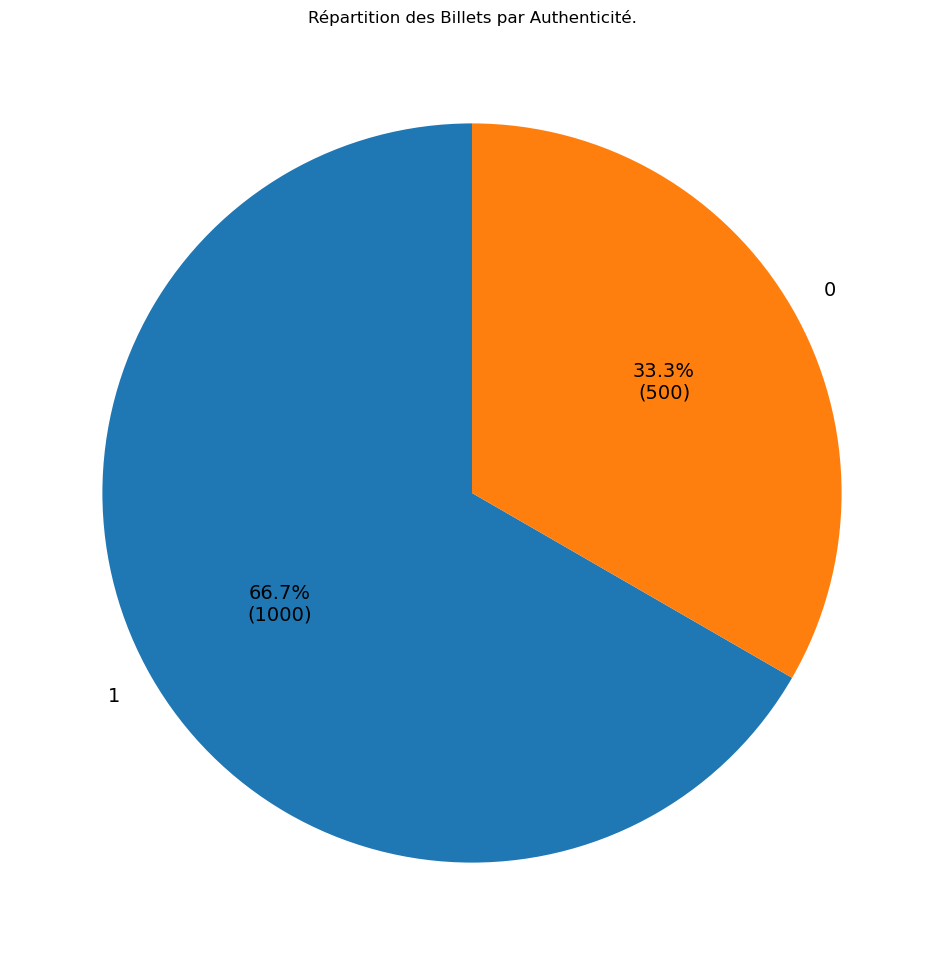

In [35]:
df_effectifs = df_billets["is_genuine"].value_counts().reset_index()
df_effectifs.columns = ["Valeur", "Effectifs"]
total_effectifs = df_effectifs["Effectifs"].sum()


# Création du diagramme circulaire
plt.figure(figsize=(12,12))
autopct_format = lambda p: f'{p:.1f}%\n({int(round(p * total_effectifs / 100))})'
couleurs = ['#f62196', '#18c0c4']
textprops = {"color": "black", "fontsize": 14}
plt.pie(df_effectifs["Effectifs"], labels=df_effectifs["Valeur"], autopct=autopct_format, startangle=90, textprops=textprops)
plt.title("Répartition des Billets par Authenticité.")

# Création du tableau
print(tabulate(df_effectifs, headers='keys', tablefmt='fancy_grid'))

plt.show()

#### Analyse univariée de chaque variable

Analyse univariée pour la variable 'is_genuine':
╒════════════╤═════════╤══════════╤═══════╤════════╕
│            │   count │   unique │   top │   freq │
╞════════════╪═════════╪══════════╪═══════╪════════╡
│ is_genuine │    1500 │        2 │     1 │   1000 │
╘════════════╧═════════╧══════════╧═══════╧════════╛


Analyse univariée pour la variable 'diagonal':
╒══════════╤═════════╤═════════╤══════════╤════════╤════════╤════════╤════════╤════════╤════════════╤════════════╕
│          │   count │    mean │      std │    min │    25% │    50% │    75% │    max │       skew │   kurtosis │
╞══════════╪═════════╪═════════╪══════════╪════════╪════════╪════════╪════════╪════════╪════════════╪════════════╡
│ diagonal │    1500 │ 171.958 │ 0.305195 │ 171.04 │ 171.75 │ 171.96 │ 172.17 │ 173.01 │ -0.0333067 │  -0.125284 │
╘══════════╧═════════╧═════════╧══════════╧════════╧════════╧════════╧════════╧════════╧════════════╧════════════╛


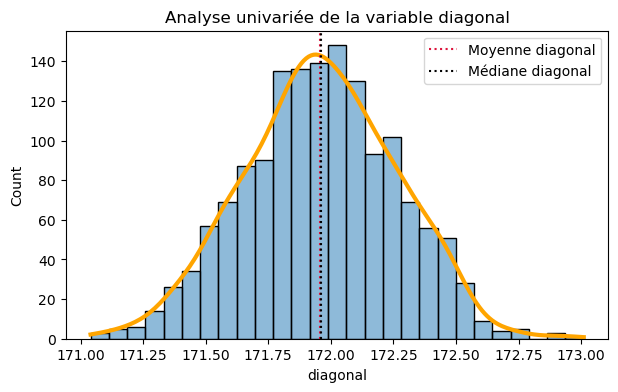

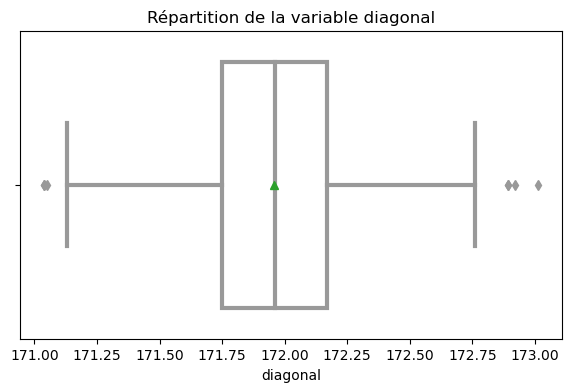



Analyse univariée pour la variable 'height_left':
╒═════════════╤═════════╤════════╤══════════╤════════╤════════╤════════╤════════╤════════╤════════════╤════════════╕
│             │   count │   mean │      std │    min │    25% │    50% │    75% │    max │       skew │   kurtosis │
╞═════════════╪═════════╪════════╪══════════╪════════╪════════╪════════╪════════╪════════╪════════════╪════════════╡
│ height_left │    1500 │ 104.03 │ 0.299462 │ 103.14 │ 103.82 │ 104.04 │ 104.23 │ 104.88 │ -0.0921206 │  -0.195271 │
╘═════════════╧═════════╧════════╧══════════╧════════╧════════╧════════╧════════╧════════╧════════════╧════════════╛


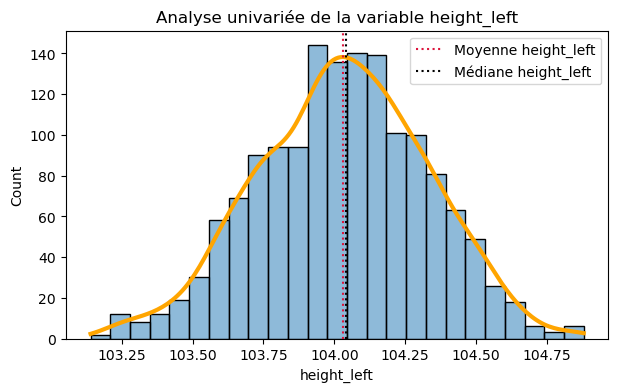

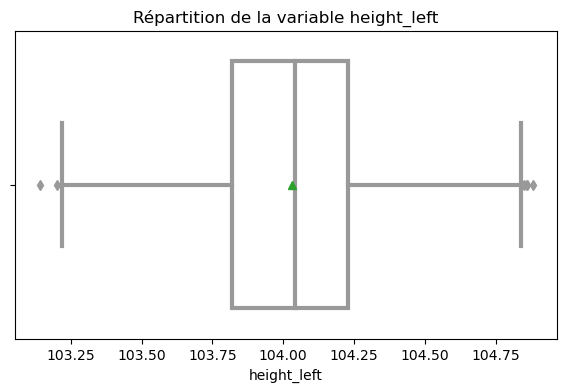



Analyse univariée pour la variable 'height_right':
╒══════════════╤═════════╤════════╤══════════╤════════╤════════╤════════╤════════╤════════╤══════════════╤════════════╕
│              │   count │   mean │      std │    min │    25% │    50% │    75% │    max │         skew │   kurtosis │
╞══════════════╪═════════╪════════╪══════════╪════════╪════════╪════════╪════════╪════════╪══════════════╪════════════╡
│ height_right │    1500 │ 103.92 │ 0.325627 │ 102.82 │ 103.71 │ 103.92 │ 104.15 │ 104.95 │ -0.000327547 │ -0.0272317 │
╘══════════════╧═════════╧════════╧══════════╧════════╧════════╧════════╧════════╧════════╧══════════════╧════════════╛


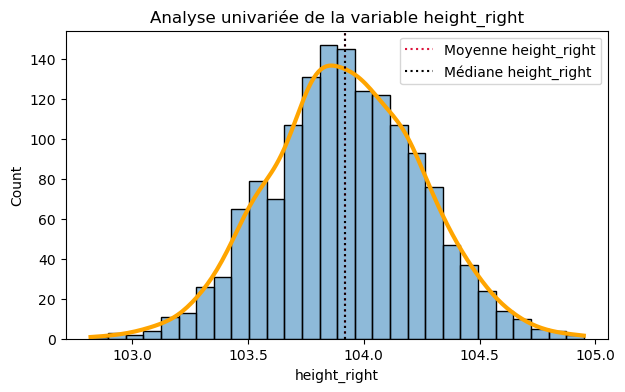

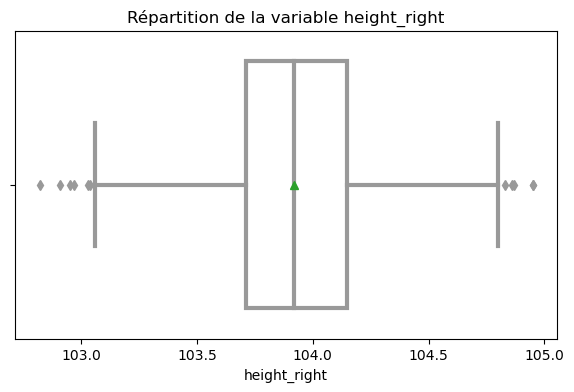



Analyse univariée pour la variable 'margin_low':
╒════════════╤═════════╤═════════╤══════════╤═══════╤════════╤═══════╤═══════╤═══════╤══════════╤════════════╕
│            │   count │    mean │      std │   min │    25% │   50% │   75% │   max │     skew │   kurtosis │
╞════════════╪═════════╪═════════╪══════════╪═══════╪════════╪═══════╪═══════╪═══════╪══════════╪════════════╡
│ margin_low │    1500 │ 4.48284 │ 0.659899 │  2.98 │ 4.0275 │  4.31 │  4.87 │   6.9 │ 0.875468 │   0.247183 │
╘════════════╧═════════╧═════════╧══════════╧═══════╧════════╧═══════╧═══════╧═══════╧══════════╧════════════╛


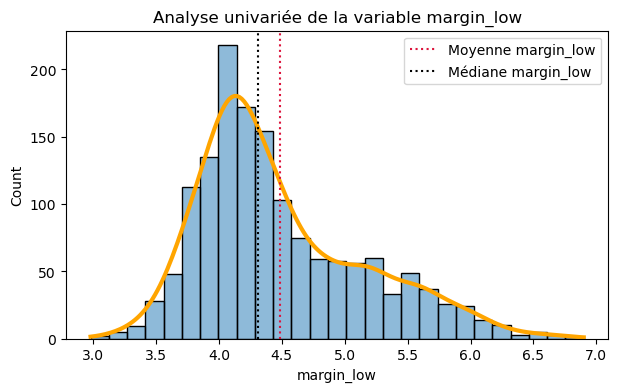

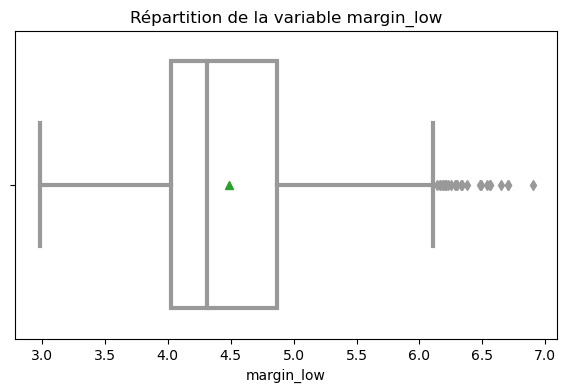



Analyse univariée pour la variable 'margin_up':
╒═══════════╤═════════╤═════════╤══════════╤═══════╤═══════╤═══════╤═══════╤═══════╤══════════╤════════════╕
│           │   count │    mean │      std │   min │   25% │   50% │   75% │   max │     skew │   kurtosis │
╞═══════════╪═════════╪═════════╪══════════╪═══════╪═══════╪═══════╪═══════╪═══════╪══════════╪════════════╡
│ margin_up │    1500 │ 3.15147 │ 0.231813 │  2.27 │  2.99 │  3.14 │  3.31 │  3.91 │ 0.145938 │  -0.245076 │
╘═══════════╧═════════╧═════════╧══════════╧═══════╧═══════╧═══════╧═══════╧═══════╧══════════╧════════════╛


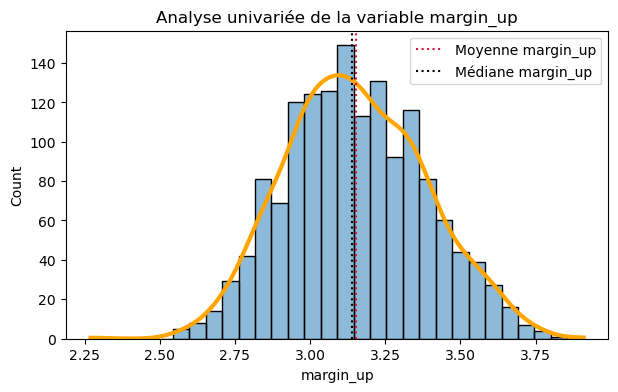

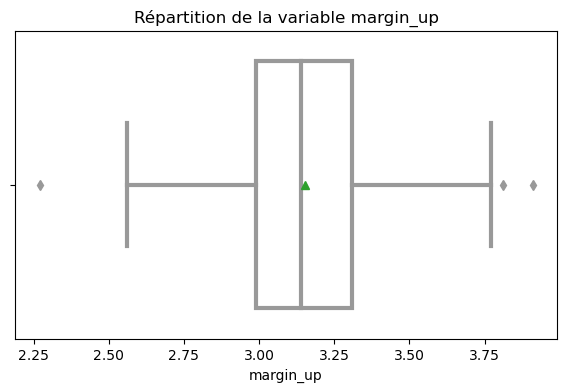



Analyse univariée pour la variable 'length':
╒════════╤═════════╤═════════╤═════════╤════════╤════════╤════════╤════════╤════════╤═══════════╤════════════╕
│        │   count │    mean │     std │    min │    25% │    50% │    75% │    max │      skew │   kurtosis │
╞════════╪═════════╪═════════╪═════════╪════════╪════════╪════════╪════════╪════════╪═══════════╪════════════╡
│ length │    1500 │ 112.678 │ 0.87273 │ 109.49 │ 112.03 │ 112.96 │ 113.34 │ 114.44 │ -0.815957 │  -0.280325 │
╘════════╧═════════╧═════════╧═════════╧════════╧════════╧════════╧════════╧════════╧═══════════╧════════════╛


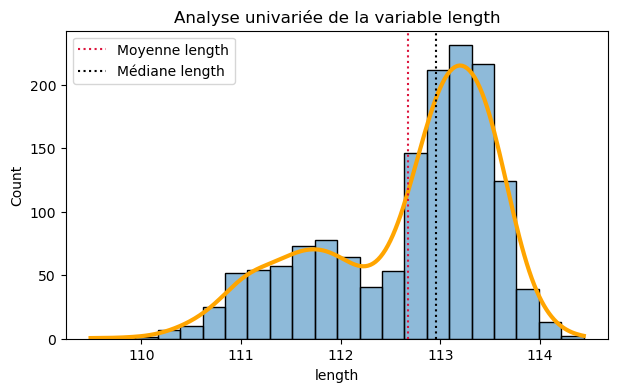

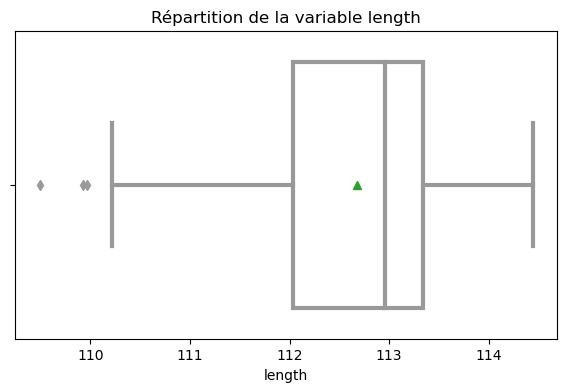

In [36]:
analyse_univariee(df_billets_full)

***

#### Analyse univariée du jeu de données séparé par Authenticité

In [37]:
df_vrai = df_billets_full.query("is_genuine == True") 
df_faux = df_billets_full.query("is_genuine == False")

Analyse univariée pour la variable 'is_genuine':
DataFrame 1
╒════════════╤═════════╤══════════╤═══════╤════════╕
│            │   count │   unique │   top │   freq │
╞════════════╪═════════╪══════════╪═══════╪════════╡
│ is_genuine │    1000 │        1 │     1 │   1000 │
╘════════════╧═════════╧══════════╧═══════╧════════╛
DataFrame 2
╒════════════╤═════════╤══════════╤═══════╤════════╕
│            │   count │   unique │   top │   freq │
╞════════════╪═════════╪══════════╪═══════╪════════╡
│ is_genuine │     500 │        1 │     0 │    500 │
╘════════════╧═════════╧══════════╧═══════╧════════╛


Analyse univariée pour la variable 'diagonal':
DataFrame 1
╒══════════╤═════════╤═════════╤══════════╤════════╤════════╤════════╤═══════╤════════╤════════════╤════════════╕
│          │   count │    mean │      std │    min │    25% │    50% │   75% │    max │       skew │   kurtosis │
╞══════════╪═════════╪═════════╪══════════╪════════╪════════╪════════╪═══════╪════════╪════════════╪════════

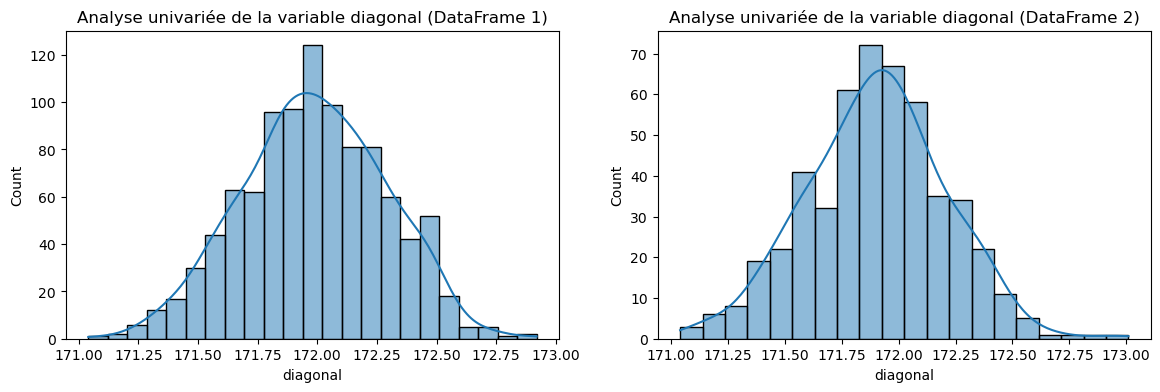

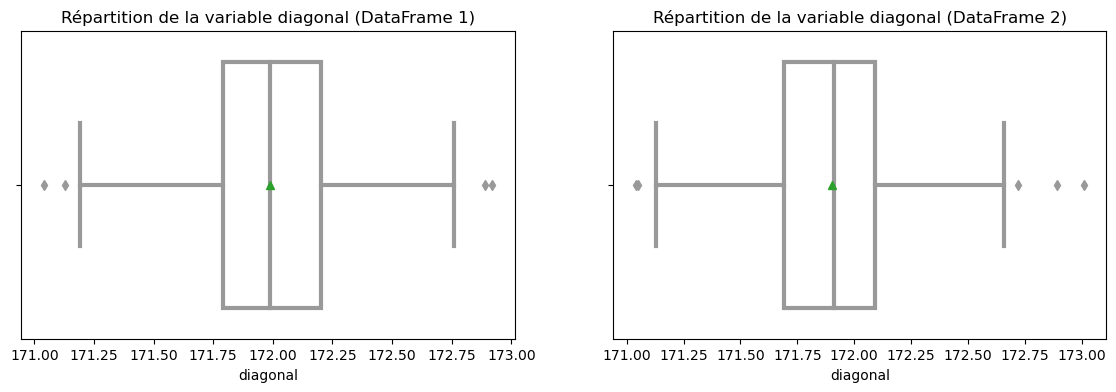



Analyse univariée pour la variable 'height_left':
DataFrame 1
╒═════════════╤═════════╤═════════╤══════════╤════════╤════════╤════════╤════════╤════════╤══════════╤════════════╕
│             │   count │    mean │      std │    min │    25% │    50% │    75% │    max │     skew │   kurtosis │
╞═════════════╪═════════╪═════════╪══════════╪════════╪════════╪════════╪════════╪════════╪══════════╪════════════╡
│ height_left │    1000 │ 103.949 │ 0.300231 │ 103.14 │ 103.74 │ 103.95 │ 104.14 │ 104.86 │ 0.150862 │  -0.117787 │
╘═════════════╧═════════╧═════════╧══════════╧════════╧════════╧════════╧════════╧════════╧══════════╧════════════╛
DataFrame 2
╒═════════════╤═════════╤════════╤══════════╤════════╤════════╤════════╤═════════╤════════╤═══════════╤════════════╕
│             │   count │   mean │      std │    min │    25% │    50% │     75% │    max │      skew │   kurtosis │
╞═════════════╪═════════╪════════╪══════════╪════════╪════════╪════════╪═════════╪════════╪═══════════╪═══════

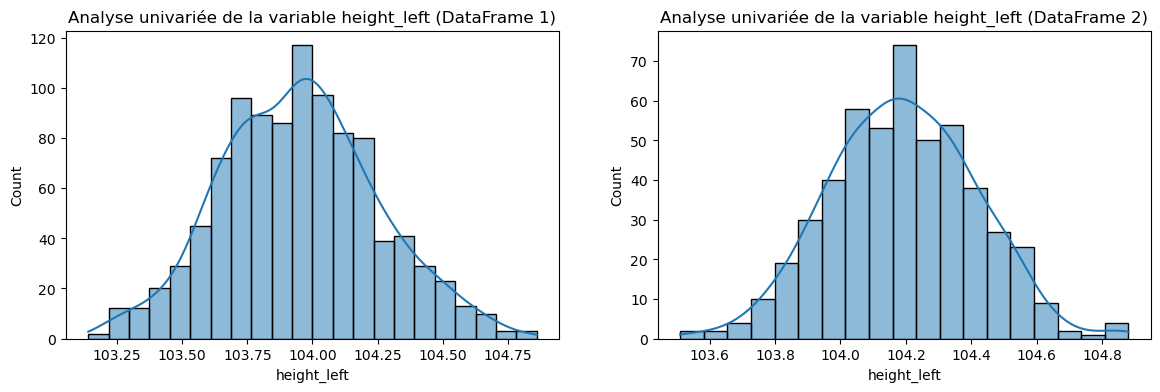

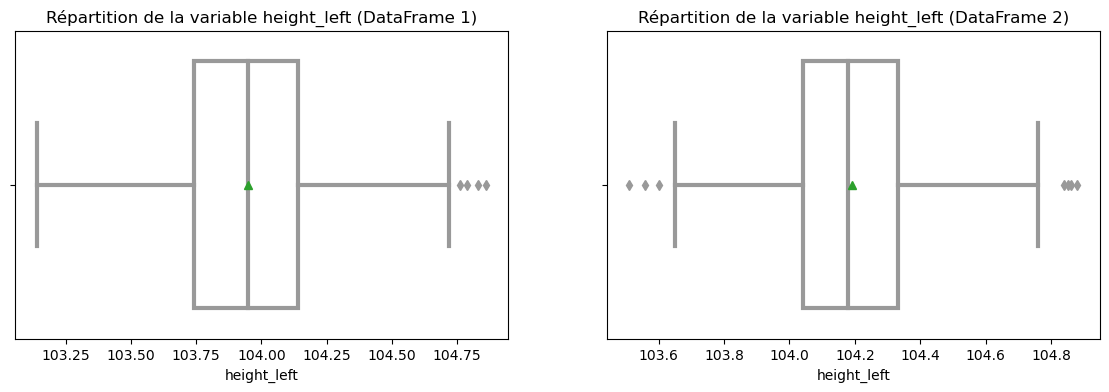



Analyse univariée pour la variable 'height_right':
DataFrame 1
╒══════════════╤═════════╤═════════╤═════════╤════════╤════════╤════════╤═══════╤════════╤═════════════╤════════════╕
│              │   count │    mean │     std │    min │    25% │    50% │   75% │    max │        skew │   kurtosis │
╞══════════════╪═════════╪═════════╪═════════╪════════╪════════╪════════╪═══════╪════════╪═════════════╪════════════╡
│ height_right │    1000 │ 103.809 │ 0.29157 │ 102.82 │ 103.61 │ 103.81 │   104 │ 104.95 │ -0.00538548 │   0.280268 │
╘══════════════╧═════════╧═════════╧═════════╧════════╧════════╧════════╧═══════╧════════╧═════════════╧════════════╛
DataFrame 2
╒══════════════╤═════════╤═════════╤══════════╤════════╤════════╤════════╤════════╤════════╤════════════╤════════════╕
│              │   count │    mean │      std │    min │    25% │    50% │    75% │    max │       skew │   kurtosis │
╞══════════════╪═════════╪═════════╪══════════╪════════╪════════╪════════╪════════╪════════╪═══

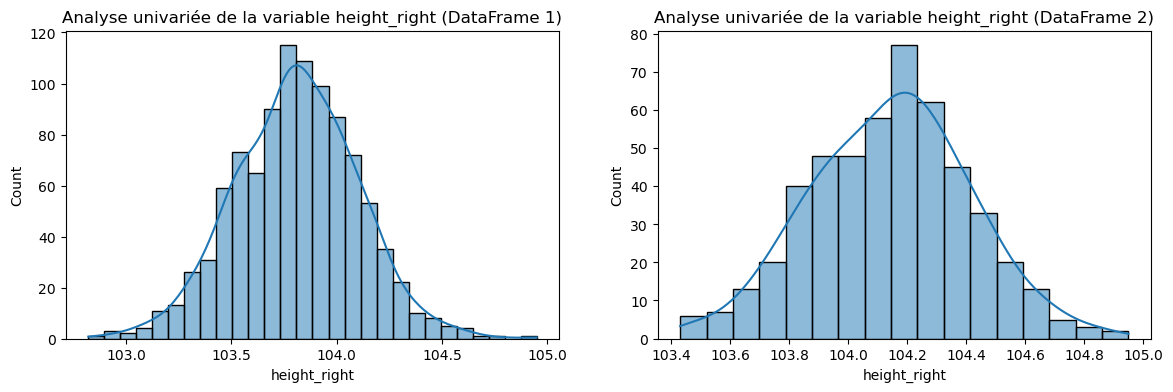

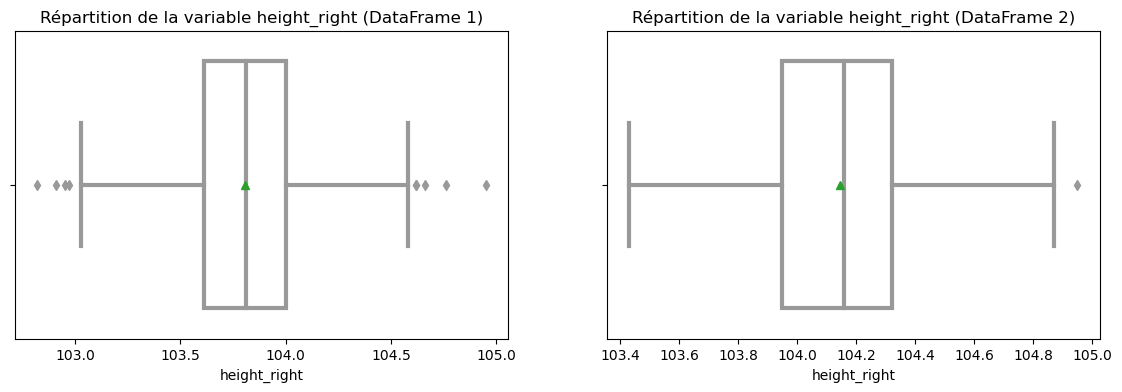



Analyse univariée pour la variable 'margin_low':
DataFrame 1
╒════════════╤═════════╤═════════╤══════════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════════╤════════════╕
│            │   count │    mean │      std │   min │   25% │   50% │   75% │   max │      skew │   kurtosis │
╞════════════╪═════════╪═════════╪══════════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════════╪════════════╡
│ margin_low │    1000 │ 4.11612 │ 0.314556 │  2.98 │  3.91 │ 4.111 │  4.33 │  5.04 │ -0.102465 │   0.140026 │
╘════════════╧═════════╧═════════╧══════════╧═══════╧═══════╧═══════╧═══════╧═══════╧═══════════╧════════════╛
DataFrame 2
╒════════════╤═════════╤═════════╤══════════╤═══════╤═══════╤═══════╤═══════╤═══════╤═════════╤════════════╕
│            │   count │    mean │      std │   min │   25% │   50% │   75% │   max │    skew │   kurtosis │
╞════════════╪═════════╪═════════╪══════════╪═══════╪═══════╪═══════╪═══════╪═══════╪═════════╪════════════╡
│ margin_low │     500 │ 5.21629 │ 0.549114

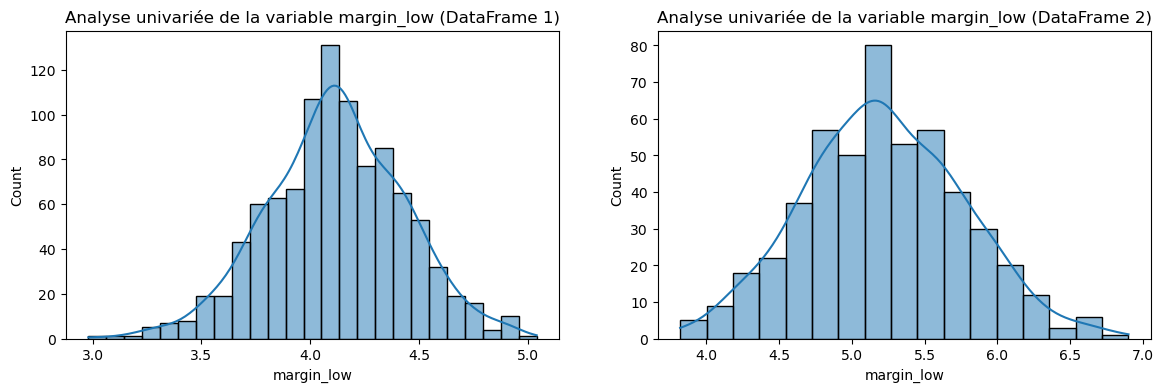

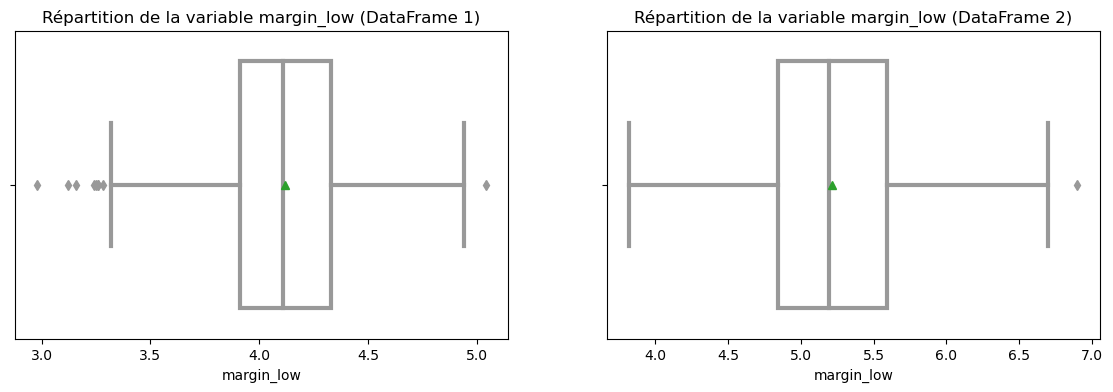



Analyse univariée pour la variable 'margin_up':
DataFrame 1
╒═══════════╤═════════╤═════════╤═════════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════════╤════════════╕
│           │   count │    mean │     std │   min │   25% │   50% │   75% │   max │      skew │   kurtosis │
╞═══════════╪═════════╪═════════╪═════════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════════╪════════════╡
│ margin_up │    1000 │ 3.05213 │ 0.18634 │  2.27 │  2.93 │  3.05 │  3.18 │  3.74 │ 0.0440806 │   0.123286 │
╘═══════════╧═════════╧═════════╧═════════╧═══════╧═══════╧═══════╧═══════╧═══════╧═══════════╧════════════╛
DataFrame 2
╒═══════════╤═════════╤═════════╤══════════╤═══════╤═══════╤═══════╤════════╤═══════╤══════════╤════════════╕
│           │   count │    mean │      std │   min │   25% │   50% │    75% │   max │     skew │   kurtosis │
╞═══════════╪═════════╪═════════╪══════════╪═══════╪═══════╪═══════╪════════╪═══════╪══════════╪════════════╡
│ margin_up │     500 │ 3.35016 │ 0.180498 │  2.92 

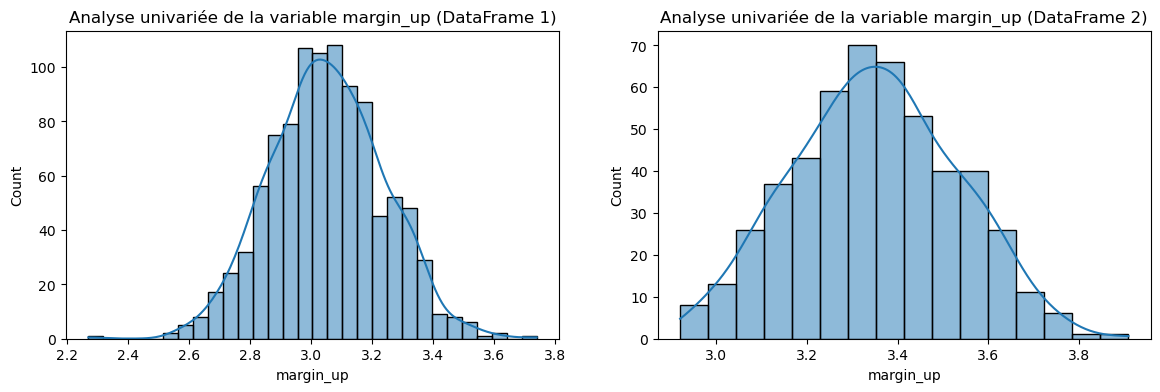

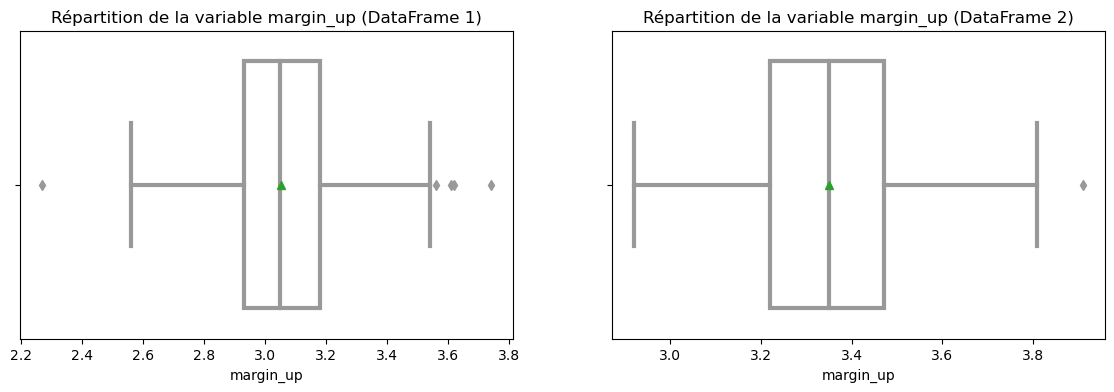



Analyse univariée pour la variable 'length':
DataFrame 1
╒════════╤═════════╤═════════╤══════════╤════════╤════════╤═════════╤════════╤════════╤════════════╤══════════════╕
│        │   count │    mean │      std │    min │    25% │     50% │    75% │    max │       skew │     kurtosis │
╞════════╪═════════╪═════════╪══════════╪════════╪════════╪═════════╪════════╪════════╪════════════╪══════════════╡
│ length │    1000 │ 113.202 │ 0.359552 │ 111.76 │ 112.95 │ 113.205 │ 113.46 │ 114.44 │ -0.0487808 │ -0.000823082 │
╘════════╧═════════╧═════════╧══════════╧════════╧════════╧═════════╧════════╧════════╧════════════╧══════════════╛
DataFrame 2
╒════════╤═════════╤═════════╤══════════╤════════╤═══════╤════════╤════════╤════════╤══════════╤════════════╕
│        │   count │    mean │      std │    min │   25% │    50% │    75% │    max │     skew │   kurtosis │
╞════════╪═════════╪═════════╪══════════╪════════╪═══════╪════════╪════════╪════════╪══════════╪════════════╡
│ length │     500 

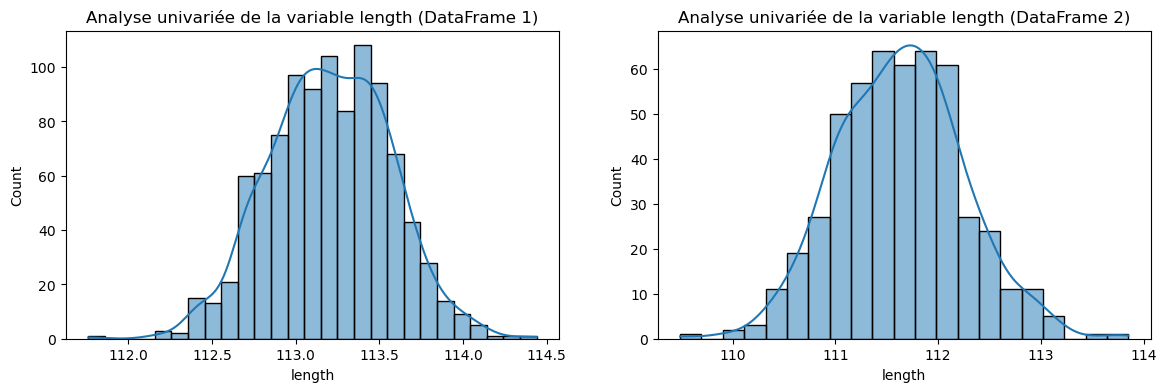

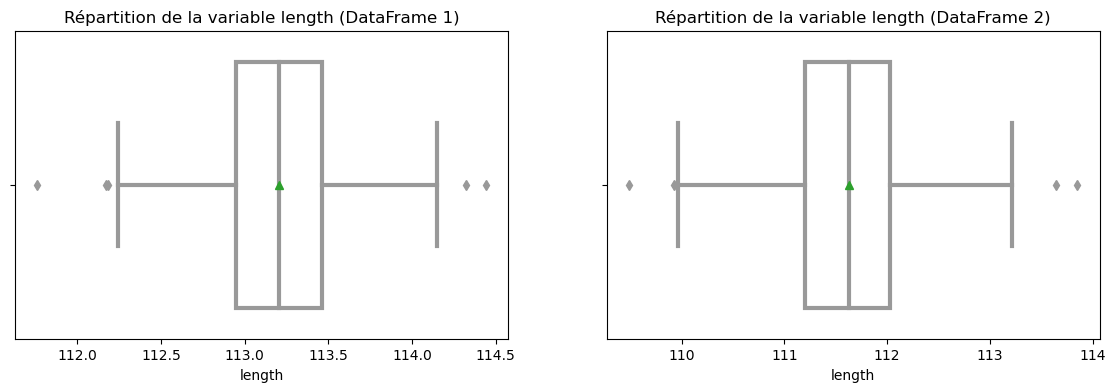

In [38]:
comp_analyse_univariee(df_vrai, df_faux)

***


## 3.2 Analyses Bivariées

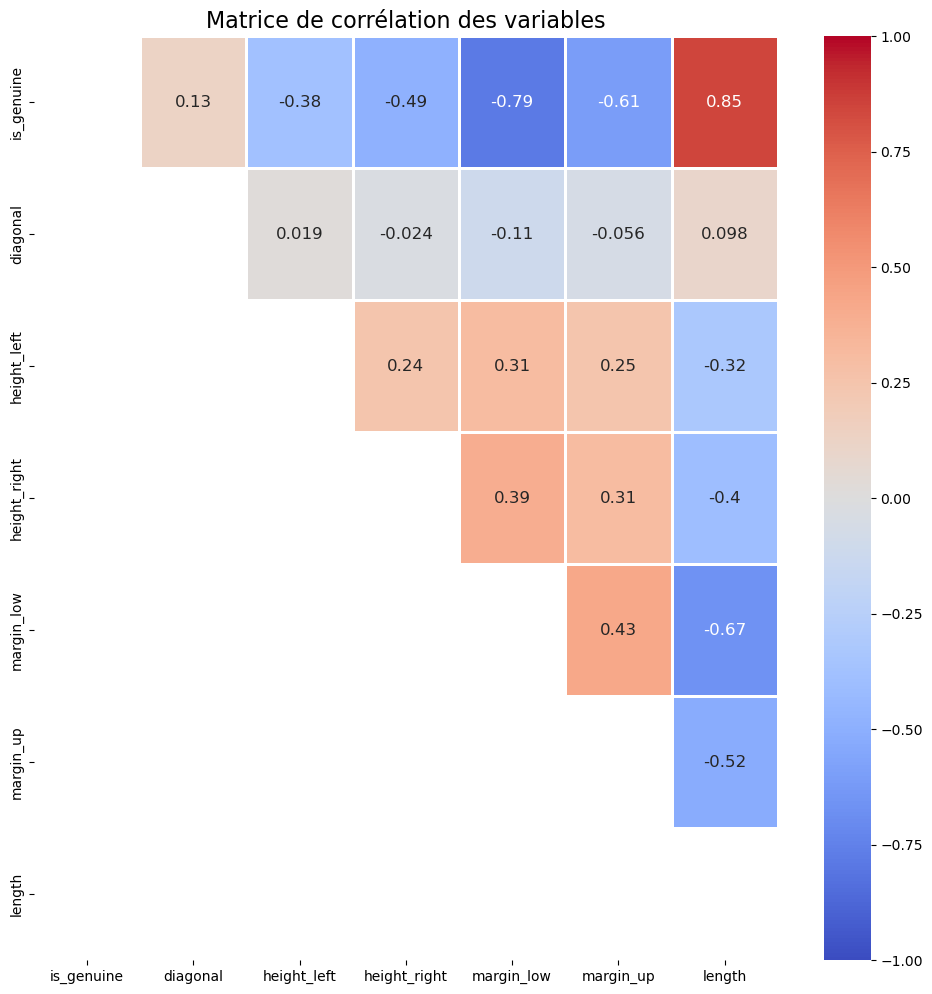

In [39]:
# Calcul la matrice de corrélation
correlation_matrix = df_billets_full.corr()

# Masque les éléments de la moitié inférieure
mask = np.tril(np.ones_like(correlation_matrix, dtype=bool))

plt.figure(figsize=(12, 12))
# Affichage de la heatmap de la moitié supérieure de la matrice de corrélation
sns.heatmap(correlation_matrix, annot=True, mask=mask, cmap='coolwarm', vmin=-1, vmax=1, linewidths=1, annot_kws={"size": 12})

plt.title("Matrice de corrélation des variables", fontsize=16)

plt.show()

<Figure size 800x800 with 0 Axes>

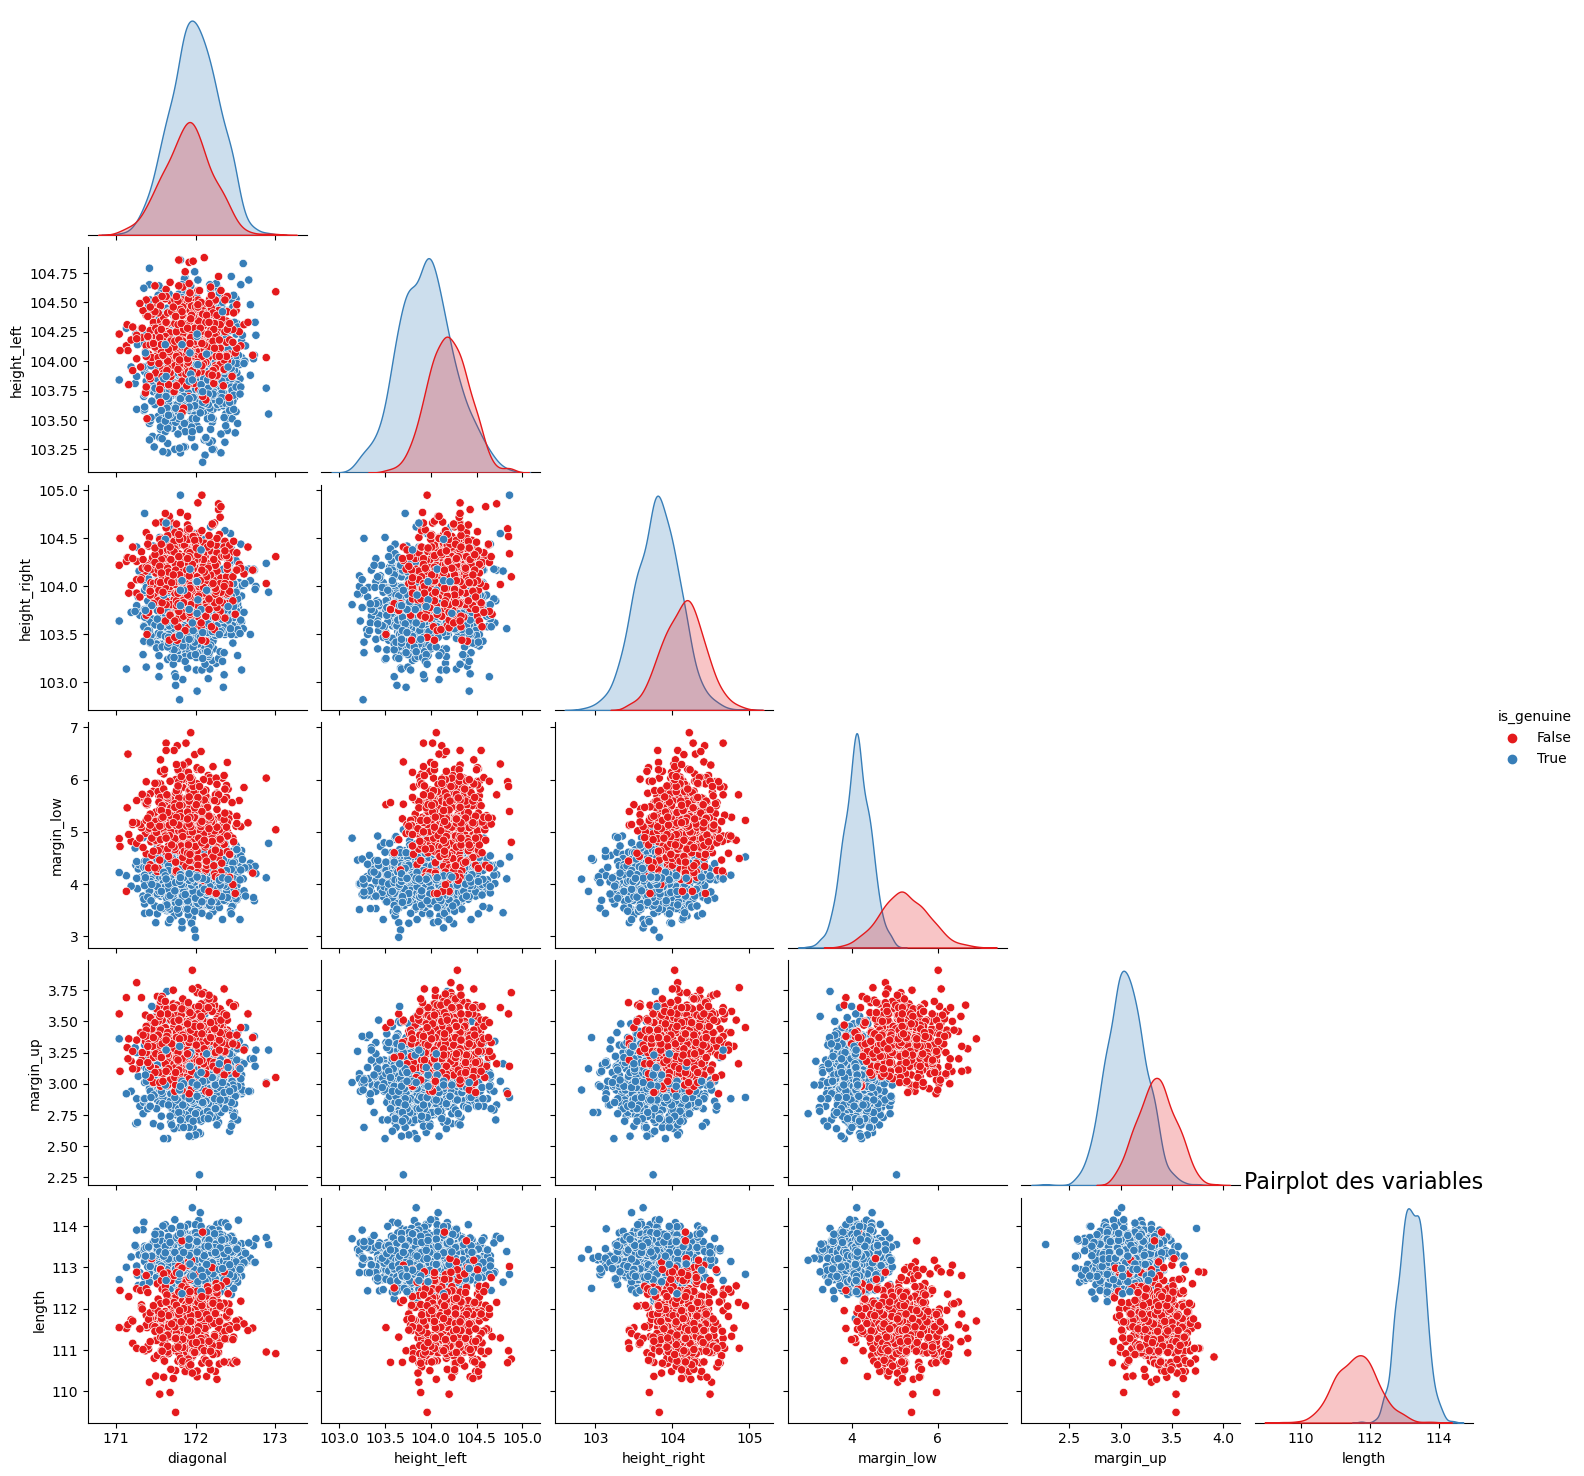

In [40]:
# Pairplot des variables et diagrammes de densité
plt.figure(figsize=(8,8))
sns.pairplot(df_billets_full, hue='is_genuine', diag_kind='kde', corner=True, height=2.5, palette='Set1')
plt.title("Pairplot des variables", fontsize=16)
plt.show()

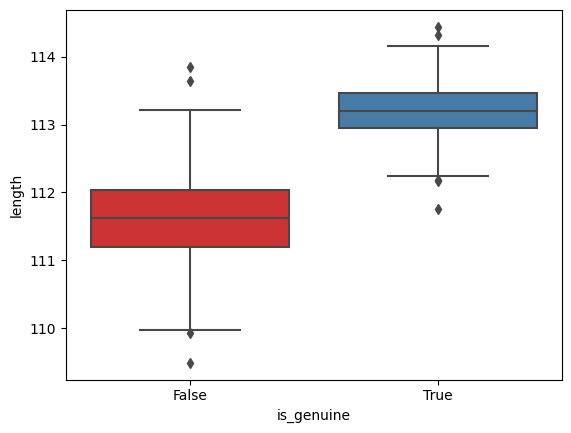

For variable 'length', t-statistic: 52.77360271974398, p-value: 1.4699545634166287e-241


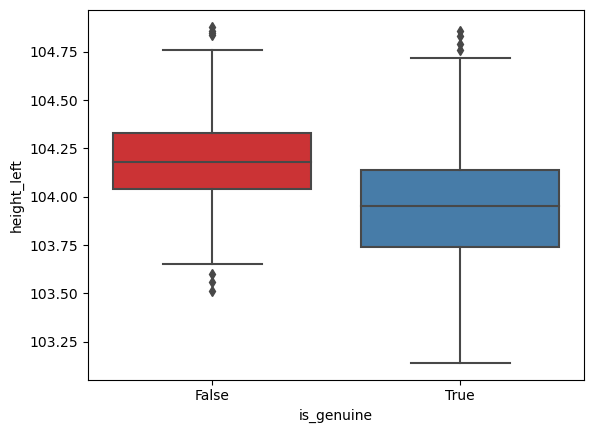

For variable 'height_left', t-statistic: -17.486602815919067, p-value: 1.4153629975651549e-61


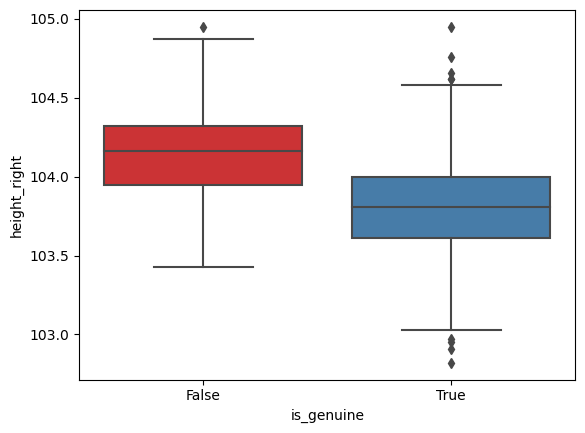

For variable 'height_right', t-statistic: -22.003138347860016, p-value: 9.287593616095777e-89


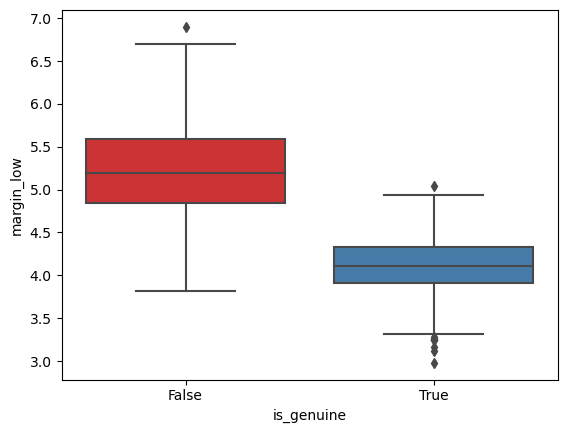

For variable 'margin_low', t-statistic: -41.52324990962482, p-value: 4.112441548546791e-187


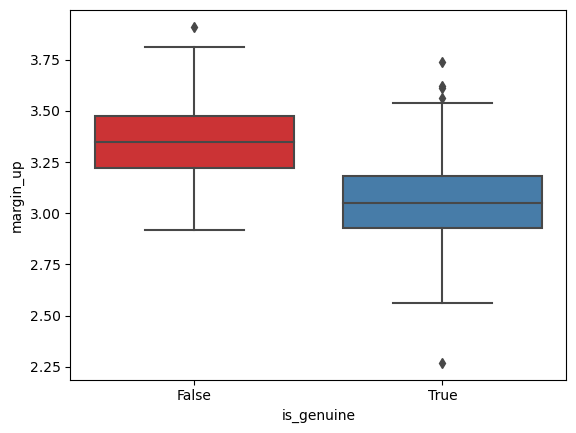

For variable 'margin_up', t-statistic: -29.820666146692933, p-value: 2.9274009689358397e-141


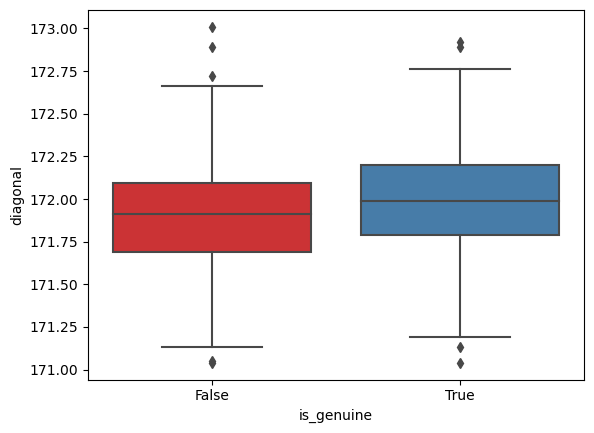

For variable 'diagonal', t-statistic: 5.147658315790662, p-value: 3.1869002032311117e-07


In [41]:
# Comparaisons des variables et t-tests
cols = ['length', 'height_left', 'height_right', 'margin_low', 'margin_up', 'diagonal']

for i in cols: 
    #  boxplot
    sns.boxplot(x='is_genuine', y=i, data=df_billets_full, palette='Set1')
    plt.show()

    #  t-test
    group1 = df_billets_full[df_billets_full['is_genuine'] == True][i]
    group2 = df_billets_full[df_billets_full['is_genuine'] == False][i]
    
    t_stat, p_val = ttest_ind(group1, group2, equal_var=False)  # assumes unequal variances
    print(f"For variable '{i}', t-statistic: {t_stat}, p-value: {p_val}")


In [42]:
def camparaison_vraifaux(df1, df2):
    # Initialise le DataFrame de résumé
    summary = pd.DataFrame()

    # Pour chaque colonne dans df1
    for col in df1.columns[1:]:
        # Calculer les statistiques descriptives pour df1 et df2
        stats_df1 = df1[col].describe().to_frame().rename(columns={col: 'df1'})
        stats_df2 = df2[col].describe().to_frame().rename(columns={col: 'df2'})

        # Concaténer les résultats
        stats = pd.concat([stats_df1, stats_df2], axis=1)

        # Calcule la différence entre les statistiques de df1 et df2
        stats['difference'] = stats['df1'] - stats['df2']

        # Ajoute le nom de la colonne au DataFrame de résumé
        stats.columns = pd.MultiIndex.from_product([[col], stats.columns])

        # Ajoute les statistiques à l'objet de résumé
        summary = pd.concat([summary, stats], axis=1)

    # Retourne le DataFrame de résumé avec une mise en forme conditionnelle
    return summary.style.applymap(lambda x: 'background-color : blue' if abs(x) > 1 else '')


# Utilisation de la fonction:
df_vraifaux = camparaison_vraifaux(df_vrai, df_faux)
df_vraifaux


****

# 4. Modélisation   

Pour la modélisation, nous allons utiliser les algorithmes suivants :
- KMeans
- Regression Logistique

Pour le reste de la modélisation, nous allons utiliser des données centrées et réduites.

In [43]:
X = df_billets_full.drop(columns=["is_genuine"])
y = df_billets_full["is_genuine"]
index = df_billets_full.index
features = df_billets_full.columns

# Centrage et réduction des variables

scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

****

# Classification non supervisée : K-means

In [44]:
X_km = X_scaled.copy()

Nous créons ensuite le modèle K-Means avec 2 clusters (pour les billets de banque authentiques et faux) et nous l'entraînons sur l'ensemble d'entraînement.

In [45]:
# Création et entraînement du modèle
kmeans = KMeans(n_clusters=2, init="k-means++", n_init=5, max_iter=300, random_state=17)
model_KMeans = kmeans.fit(X_km)

In [46]:
# Récupération des clusters et des centroïdes de clusters
clusters = model_KMeans.labels_
centroids = model_KMeans.cluster_centers_

In [47]:
# Prédiction des clusters
y_pred_km = model_KMeans.predict(X_km)

#### Nous calculons et traçons la matrice de confusion pour avoir une meilleure idée des types d'erreurs que le modèle fait.


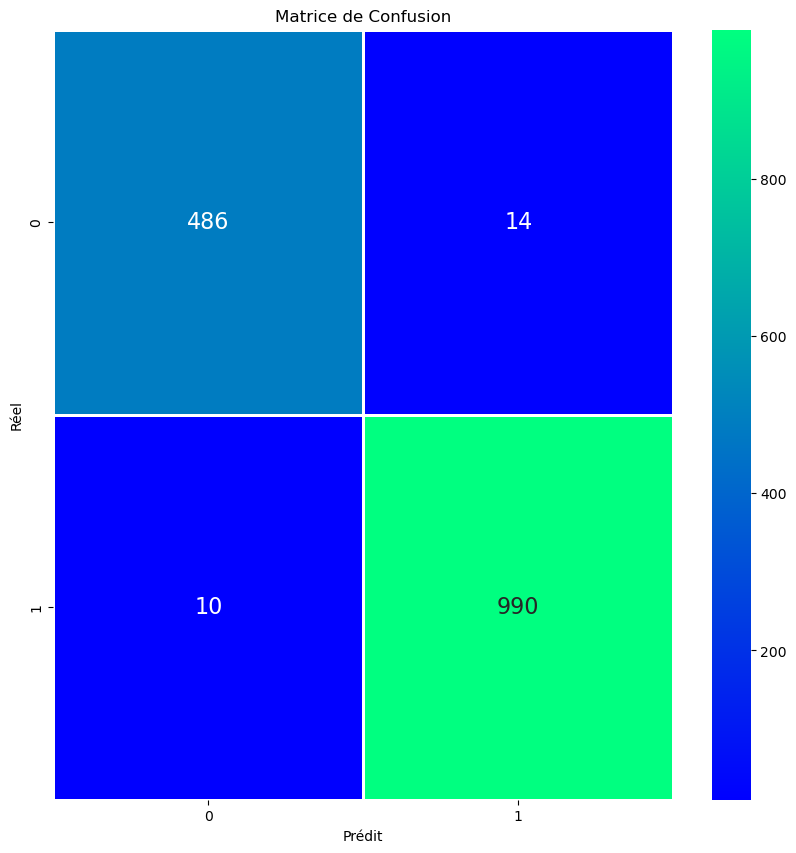

In [48]:
# Matrice de confusion
cm = confusion_matrix(y, y_pred_km)
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='d', linewidths=1, annot_kws={"size": 16}, cmap='winter')
plt.title('Matrice de Confusion')
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.show()

In [49]:
# Récupération des valeurs de la matrice de confusion
vn, fp, fn, vp = cm.ravel()

# Calcul des pourcentages
taux_vrai_positif = vp / (vp + fn)*100
taux_faux_positif = fp / (fp + vn)*100
taux_vrai_negatif = vn / (vn + fp)*100
taux_faux_negatif = fn / (fn + vp)*100

# Affichage des résultats
print(f"Vrai positif : {taux_vrai_positif}%")
print(f"Faux positif : {taux_faux_positif}%")
print(f"Vrai négatif : {taux_vrai_negatif}%")
print(f"Faux négatif : {taux_faux_negatif}%")

Vrai positif : 99.0%
Faux positif : 2.8000000000000003%
Vrai négatif : 97.2%
Faux négatif : 1.0%


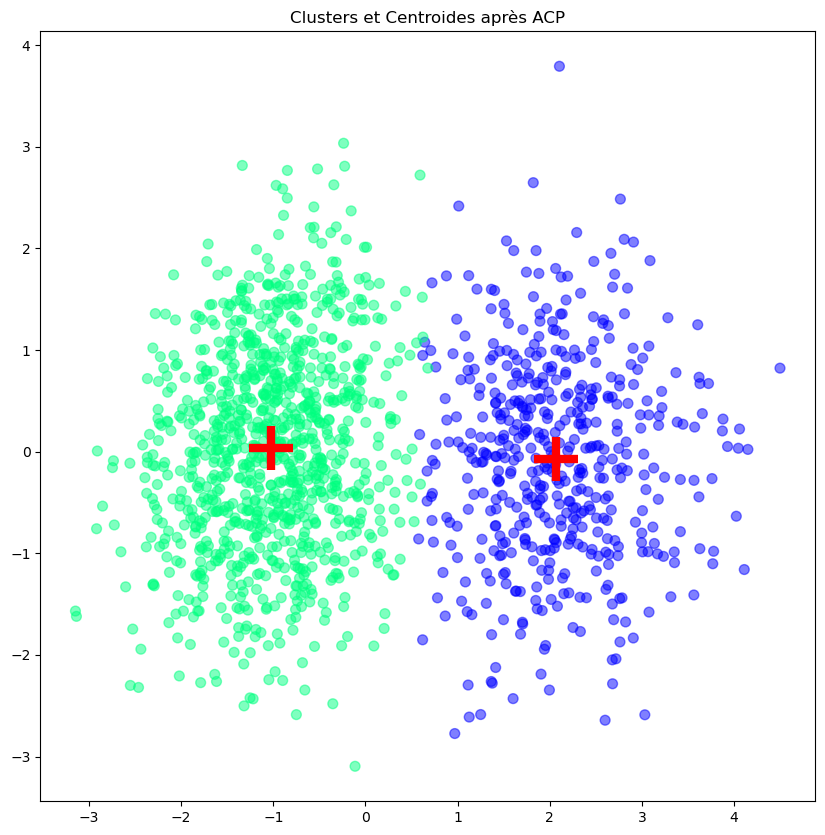

In [50]:
# Nous appliquons l'ACP pour réduire la dimensionnalité des données à 2 dimensions pour la visualisation.
# Ensuite, nous traçons les points de données et les centres de clusters.
acp = PCA(n_components=3)
X_acp = acp.fit_transform(X_km)
centroides_acp = acp.transform(centroids)
plt.figure(figsize=(10,10))
plt.scatter(X_acp[:, 0], X_acp[:, 1],c=y_pred_km, cmap='winter', s=50, alpha=0.5)
plt.scatter(centroides_acp[:, 0], centroides_acp[:, 1], c='red', marker='+', s=1000, linewidth=6)
plt.title('Clusters et Centroides après ACP')
plt.show()

In [51]:

# Nous appliquons l'ACP pour réduire la dimensionnalité des données à 3 dimensions pour la visualisation.
# Ensuite, nous traçons les points de données et les centres de clusters.
acp = PCA(n_components=3)
X_acp = acp.fit_transform(X_km)

# Récupération des coordonnées des centroids dans l'espace ACP
centroids_acp = acp.transform(centroids)

# Création de la figure
fig = go.Figure()

# Ajout du traceur pour les points de données
fig.add_trace(go.Scatter3d(
    x=X_acp[:, 0],
    y=X_acp[:, 1],
    z=X_acp[:, 2],
    mode='markers',
    marker=dict(
        size=4,
        color=y_pred_km,
        colorscale='tealrose',
        opacity=0.2
    ),
    name='Données'
))

# Ajout du traceur pour les centroids
fig.add_trace(go.Scatter3d(
    x=centroids_acp[:, 0],
    y=centroids_acp[:, 1],
    z=centroids_acp[:, 2],
    mode='markers',
    marker=dict(
        size=10,
        color='yellow',
        symbol='x',
        opacity=1.0
    ),
    name='Centroids'
))

# Personnalisation de la mise en page et affichage de la figure
fig.update_layout(
    scene=dict(
        xaxis=dict(title='Composante 1'),
        yaxis=dict(title='Composante 2'),
        zaxis=dict(title='Composante 3')
    ),
    title='Projection en 3D des données après ACP avec les centroides'
)
fig.show()

L'ARI varie de -1 à 1, où une valeur proche de 1 indique une concordance parfaite entre les deux ensembles d'étiquettes, une valeur proche de 0 indique une similarité aléatoire et une valeur proche de -1 indique une discordance complète.

In [52]:
# Calcul de l'ARI
ari = adjusted_rand_score(y, y_pred_km)

# Affichage de l'ARI
print("Adjusted Rand Index (ARI) :", ari)


Adjusted Rand Index (ARI) : 0.9361771423949447


- **Accuracy** : L'exactitude est la proportion de prédictions correctes parmi le total des prédictions. C'est un bon indicateur lorsque les classes sont équilibrées : 
     $$Accuracy = \frac{TP + TN}{TP + TN + FP + FN}$$

     Où TP est le nombre de vrais positifs, TN est le nombre de vrais négatifs, FP est le nombre de faux positifs et FN est le nombre de faux négatifs.

- **Precision** : La précision est la proportion de prédictions positives qui sont réellement positives. Elle est utilisée lorsque le coût des faux positifs est élevé : 
- 
     $$Precision = \frac{TP}{TP + FP}$$

- **Recall** (ou sensibilité) : Le rappel est la proportion de vrais positifs qui sont correctement prédits comme tels. Il est utilisé lorsque le coût des faux négatifs est élevé. : 
     $$Recall = \frac{TP}{TP + FN}$$

- **F1-score** : Le score F1 est une moyenne harmonique de la précision et du rappel. Il donne un équilibre entre ces deux mesures. :
- 
     $$F1 = 2 \times \frac{Precision \times Recall}{Precision + Recall}$$


In [53]:
# Nous calculons plusieurs indicateurs pour évaluer la performance du modèle.
accuracy_KMeans = accuracy_score(y, y_pred_km)
precision_KMeans = precision_score(y, y_pred_km)
recall_KMeans = recall_score(y, y_pred_km)
f1_KMeans = f1_score(y, y_pred_km)
print(f'Accuracy: {accuracy_KMeans}')
print(f'Precision: {precision_KMeans}')
print(f'Recall: {recall_KMeans}')
print(f'F1 Score: {f1_KMeans}')

Accuracy: 0.984
Precision: 0.9860557768924303
Recall: 0.99
F1 Score: 0.9880239520958083


Utilisation de l'algorithme K-means sur un jeu de test

In [54]:
df_test = pd.read_csv("billets_production.csv")
# Mettre 'id' en index
df_test.set_index('id', inplace=True)
# Normaliser les données
scaler = StandardScaler()
X_dftest = scaler.fit_transform(df_test)
# Faire des prédictions
y_preddftest = model_KMeans.predict(X_dftest)
# Convertir les prédictions en "vrai" ou "faux"
y_preddftest = ['Vrai' if pred == 1 else 'Faux' for pred in y_preddftest]
# Ajouter les prédictions et les probabilités au DataFrame
df_test['Authenticite'] = y_preddftest
df_test

diagonal  height_left  height_right  margin_low  margin_up  length  \
id                                                                        
A_1    171.76       104.01        103.54        5.21       3.30  111.42   
A_2    171.87       104.17        104.13        6.00       3.31  112.09   
A_3    172.00       104.58        104.29        4.99       3.39  111.57   
A_4    172.49       104.55        104.34        4.44       3.03  113.20   
A_5    171.65       103.63        103.56        3.77       3.16  113.33   

    Authenticite  
id                
A_1         Faux  
A_2         Faux  
A_3         Faux  
A_4         Vrai  
A_5         Vrai

***

# Régression Logistique

Création d'une copie du jeu de données qui a été préalablement centré et réduit pour être utilisé dans la régression logistique.

In [55]:
# Copie des données centrées et réduites
X_rl = X_scaled.copy()

Division du jeu de données en un ensemble d'entraînement et un ensemble de test. 

- ``test_size=0.2`` signifie que 20% des données sont réservées pour l'ensemble de test.
- ``random_state=17`` est utilisé pour garantir que la division des données soit reproductible. 
- ``stratify=y`` garantit que les proportions de classes dans les ensembles d'entraînement et de test sont les mêmes que dans l'ensemble de données original.

In [56]:
# Train test split
X_rl_train, X_rl_test, y_rl_train, y_rl_test = train_test_split(X_rl, y, test_size=0.2, random_state=17, stratify=y)

In [57]:
# Affichage de la forme des différents ensembles
X_rl_train.shape, X_rl_test.shape, y_rl_train.shape, y_rl_test.shape

((1200, 6), (300, 6), (1200,), (300,))

In [58]:
# Vérification des proportions de la variable cible entre le train et le test
y_rl_train.value_counts(normalize=True), y_rl_test.value_counts(normalize=True)

(True     0.666667
 False    0.333333
 Name: is_genuine, dtype: float64,
 True     0.666667
 False    0.333333
 Name: is_genuine, dtype: float64)

### Étape 1: Construction et entraînement du modèle

In [59]:
# Nous créons d'abord le modèle de régression logistique et l'entraînons sur l'ensemble d'entraînement.
model_rl = LogisticRegression()
model_rl.fit(X_rl_train, y_rl_train)

LogisticRegression()

In [60]:
coeficients = model_rl.coef_[0]
coeficients

array([ 0.20095989, -0.34679666, -0.8370899 , -2.77118199, -1.70958479,
        3.38390625])

### Étape 2: Prédiction sur l'ensemble de test


In [61]:
# Prédiction sur l'ensemble de test
y_rl_pred = model_rl.predict(X_rl_test)

In [62]:
# Prédiction des probabilités de la classe positive
y_rl_proba = model_rl.predict_proba(X_rl_test)[:, 1]

### Étape 3: Évaluation du modèle

Nous utilisons la validation croisée pour évaluer la performance du modèle sur différentes parties de l'ensemble d'entraînement.

Ici, nous utilisons une validation croisée à 5 plis, ce qui signifie que l'ensemble d'entraînement est divisé en 5 parties, le modèle est entraîné et testé 5 fois, à chaque fois sur une partie différente de l'ensemble d'entraînement.

In [63]:
# Validation croisée
cv_scores = cross_val_score(model_rl, X_rl_train, y_rl_train, cv=5, scoring="recall")

# Afficher les scores de validation croisée
print(f"Scores de validation croisée: {cv_scores}")
print(f"Moyenne des scores de validation croisée: {np.mean(cv_scores)}")

Scores de validation croisée: [1.      1.      0.9875  0.99375 1.     ]
Moyenne des scores de validation croisée: 0.9962499999999999


#### La matrice de confusion nous permet de visualiser la performance du modèle en termes de faux positifs, de faux négatifs, de vrais positifs et de vrais négatifs.

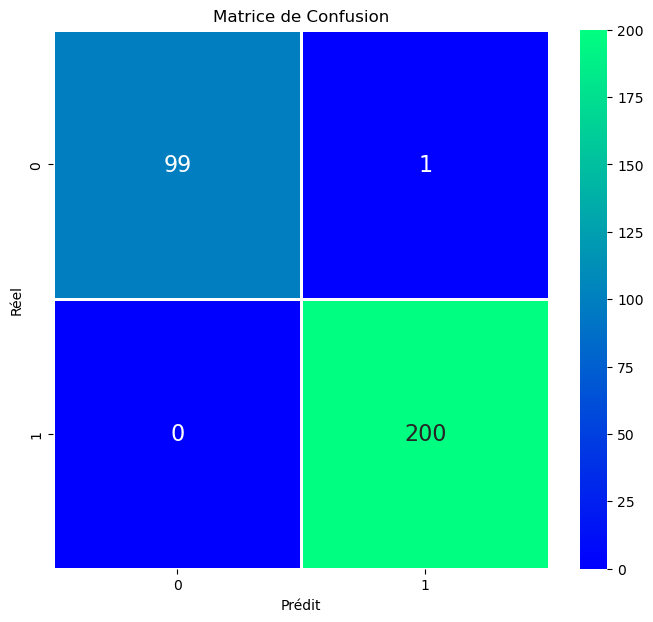

In [64]:
# Matrice de confusion
cm_rl = confusion_matrix(y_rl_test, y_rl_pred)

# Affiche la matrice de confusion
plt.figure(figsize=(8,7))
sns.heatmap(cm_rl, annot=True, fmt='d', linewidths=1, annot_kws={"size": 16}, cmap='winter')
plt.title("Matrice de Confusion")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.show()

In [65]:
# Calcul des taux à partir de la matrice de confusion
TN_test, FP_test, FN_test, TP_test = cm_rl.ravel()

# Calcul des taux pour l'ensemble de test
TPR_test = TP_test / (TP_test + FN_test)  *100 # Taux de vrais positifs (rappel)
FPR_test = FP_test / (FP_test + TN_test)  *100 # Taux de faux positifs
TNR_test = TN_test / (TN_test + FP_test)  *100 # Taux de vrais négatifs (spécificité)
FNR_test = FN_test / (FN_test + TP_test)  *100 # Taux de faux négatifs

# Affichage des taux pour l'ensemble de test
print(f"Taux de vrais positifs (rappel) : {TPR_test}%")
print(f"Taux de faux positifs : {FPR_test}%")
print(f"Taux de vrais négatifs (spécificité) : {TNR_test}%")
print(f"Taux de faux négatifs : {FNR_test}%")


Taux de vrais positifs (rappel) : 100.0%
Taux de faux positifs : 1.0%
Taux de vrais négatifs (spécificité) : 99.0%
Taux de faux négatifs : 0.0%


In [66]:
accuracy = accuracy_score(y_rl_test, y_rl_pred)

# La précision est le ratio des vrais positifs sur l'ensemble des prédictions positives. 
# C'est une mesure de la capacité du modèle à ne pas étiqueter comme positif un échantillon qui est négatif.
precision = precision_score(y_rl_test, y_rl_pred)

# Le rappel (ou sensibilité) est le ratio des vrais positifs sur l'ensemble des vrais positifs et des faux négatifs. 
# C'est une mesure de la capacité du modèle à trouver tous les échantillons positifs.
recall = recall_score(y_rl_test, y_rl_pred)

# Le score F1 est la moyenne harmonique de la précision et du rappel. Il cherche à combiner les deux en une seule mesure.
f1 = f1_score(y_rl_test, y_rl_pred)

# Afficher les métriques
print(f"Exactitude : {accuracy}")
print(f"Précision: {precision}")
print(f"Rappel: {recall}")
print(f"Score F1: {f1}")


Exactitude : 0.9966666666666667
Précision: 0.9950248756218906
Rappel: 1.0
Score F1: 0.9975062344139651



- **ROC Curve** : La courbe ROC (Receiver Operating Characteristic) est un graphique qui illustre la performance d'un modèle de classification pour tous les seuils de classification. Elle trace le taux de vrais positifs (sensibilité) en fonction du taux de faux positifs (1-spécificité). 

- **AUC** : L'AUC (Area Under the Curve) est l'aire sous la courbe ROC. Elle fournit une mesure agrégée de la performance du modèle de classification à tous les seuils de classification possibles. Elle peut aussi être interprétée comme la probabilité qu'un classificateur rangera un exemple positif aléatoirement choisi plus haut qu'un exemple négatif aléatoirement choisi. Les valeurs vont de 0 à 1, où une valeur de 0,5 correspond à un modèle aléatoire et une valeur de 1 correspond à un modèle parfait.

- **ROC-AUC score** : Le score ROC-AUC est simplement la valeur numérique pour l'AUC. Il est utilisé comme une mesure de la performance globale d'un modèle de classification.

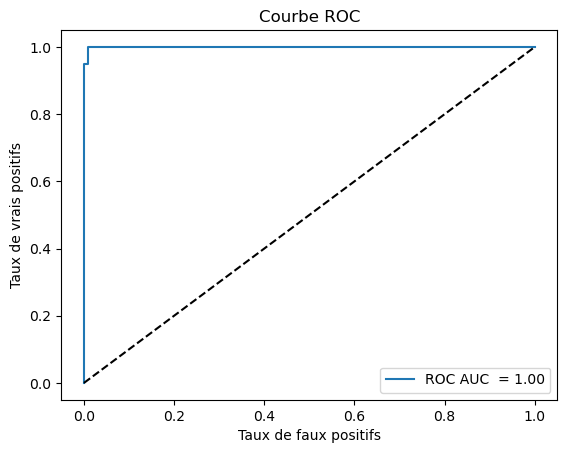

In [67]:
# Calculer les probabilités de prédiction
y_rl_prob = model_rl.predict_proba(X_rl_test)[:, 1]

# Calculer le taux de faux positifs et le taux de vrais positifs
fpr, tpr, thresholds = roc_curve(y_rl_test, y_rl_prob)
roc_auc = auc(fpr, tpr)

# Afficher la courbe ROC et l'AUC
plt.figure()
plt.plot(fpr, tpr, label="ROC AUC  = %0.2f" % roc_auc)
plt.plot([0, 1], [0, 1], "k--")

plt.title("Courbe ROC")
plt.xlabel("Taux de faux positifs")
plt.ylabel("Taux de vrais positifs")
plt.legend(loc="lower right")
plt.show()


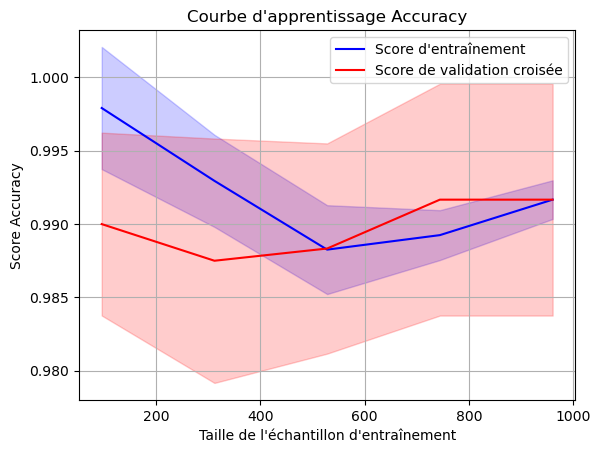

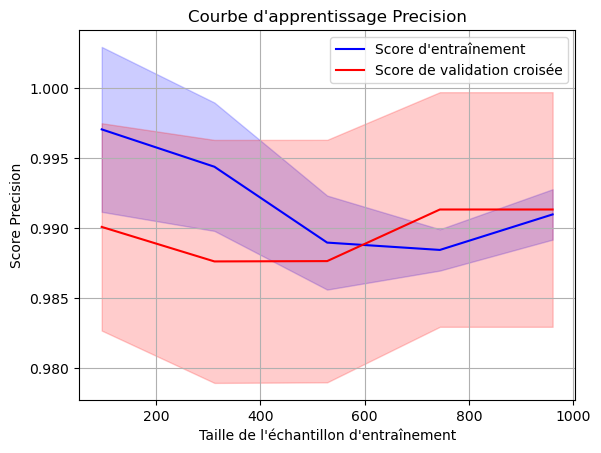

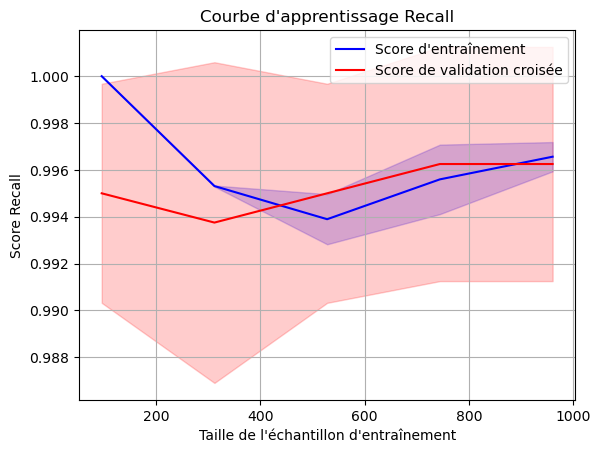

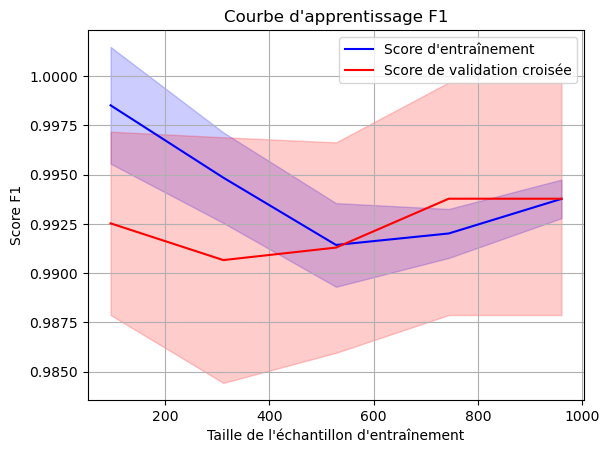

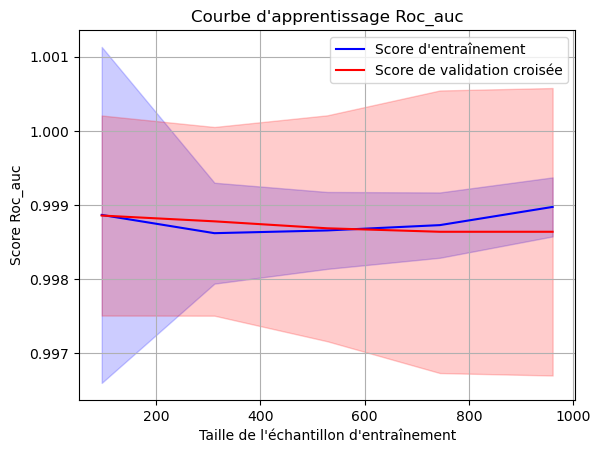

In [68]:
# Création d'une liste d'indiquateurs à utiliser
metrics = ["accuracy", "precision", "recall", "f1", "roc_auc"]

# Pour chaque indicateur dans notre liste
for metric in metrics:
    # Génération des scores d'apprentissage et de test en utilisant la validation croisée
    train_sizes, train_scores, test_scores = learning_curve(model_rl, X_rl_train, y_rl_train, cv=5, scoring=metric)

    # Calcul de la moyenne et l'écart-type des scores d'apprentissage et de test
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # Création d'une nouvelle figure
    plt.figure()

    # Trace les courbes d'apprentissage pour les scores d'apprentissage et de test
    plt.plot(train_sizes, train_mean, label=f"Score d'entraînement", color="blue")
    plt.plot(train_sizes, test_mean, label="Score de validation croisée", color="red")

    # Ajout des bandes pour indiquer l'écart-type des scores d'apprentissage et de test
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="blue", alpha=0.2)
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="red", alpha=0.2)

    # Ajout des titres et des labels aux axes
    plt.title(f"Courbe d'apprentissage {metric.capitalize()}")
    plt.xlabel("Taille de l'échantillon d'entraînement")
    plt.ylabel(f"Score {metric.capitalize()}")
    plt.legend(loc="best")
    plt.grid()

    plt.show()


****

# Choix du Model

Dans notre contexte de détection de faux billets, où il est crucial de détecter tous les faux billets, la Régression Logistique semble être le meilleur choix :

1. Recall de 100% : La Régression Logistique est capable de détecter tous les faux billets présents dans notre ensemble de données. 

2. Précision élevée : La Régression Logistique présente une précision de 99.5% sur la classe 'False', ce qui indique que les billets prédits comme faux sont très susceptibles d'être réellement des faux billets.

3. Exactitude globale élevée : L'exactitude globale de la Régression Logistique est de 99.7%. 


# Algorithmes de classification supervisée :

In [69]:
def detection_faux_billets(csv_file, model):
    """
    Cette fonction prend en entrée un fichier CSV et un modèle de régression logistique entraîné, 
    et renvoie un DataFrame avec des prédictions d'authenticité pour chaque billet dans le fichier CSV.

    Paramètres :
    csv_file (str) : Le chemin vers le fichier CSV. Le fichier CSV doit contenir une colonne 'id' 
                     et des colonnes pour chaque variable indépendante.
    model : Un modèle de Machine Learning entraîné.

    Retourne :
    df (DataFrame) : Un DataFrame contenant les données originales du fichier CSV, ainsi qu'une 
                     colonne 'Authenticite' avec des prédictions d'authenticité pour chaque billet 
                     ('Vrai' pour authentique, 'Faux' pour non authentique), et une colonne 
                     'Probabilite_authenticite' avec la probabilité associée à chaque prédiction.
    """
    # Lire le fichier CSV
    df = pd.read_csv(csv_file)

    # Mettre 'id' en index
    df.set_index('id', inplace=True)

    # Normaliser les données
    scaler = StandardScaler()
    X = scaler.fit_transform(df)

    # Faire des prédictions
    y_pred = model.predict(X)

    # Calculer les probabilités
    probabilites = model.predict_proba(X)

    # Convertir les prédictions en "vrai" ou "faux"
    y_pred = ['Vrai' if pred == 1 else 'Faux' for pred in y_pred]

    # Ajouter les prédictions et les probabilités au DataFrame
    df['Authenticite'] = y_pred
    df['Probabilite_authenticite'] = probabilites[:, 1]

    return df


### Test de l'algorithme de regression logistique sur un jeu de test

In [70]:
detection_faux_billets('billets_production.csv', model_rl)

diagonal  height_left  height_right  margin_low  margin_up  length  \
id                                                                        
A_1    171.76       104.01        103.54        5.21       3.30  111.42   
A_2    171.87       104.17        104.13        6.00       3.31  112.09   
A_3    172.00       104.58        104.29        4.99       3.39  111.57   
A_4    172.49       104.55        104.34        4.44       3.03  113.20   
A_5    171.65       103.63        103.56        3.77       3.16  113.33   

    Authenticite  Probabilite_authenticite  
id                                          
A_1         Faux                  0.055232  
A_2         Faux                  0.010366  
A_3         Faux                  0.008358  
A_4         Vrai                  0.999899  
A_5         Vrai                  0.999997